# RNN单元

In [1]:
from torch import nn
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,  # rnn hidden unit
            num_layers=num_layers,  # number of rnn layer

            batch_first=True,
        )
        self.out = nn.Linear(hidden_size,output_size)

    def forward(self, x, h_state):
        r_out, h_state = self.rnn(x, h_state)

        out = self.out(r_out[:,-1,:])
        return out

# LSTM单元

In [ ]:
# from torch import nn
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        r_out, (h_n,h_c) = self.rnn(x,None)

        out = self.out(r_out[:, -1, :])
        return out

# GRU单元

In [ ]:
from torch import nn
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()

        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,

            batch_first=True,
        )
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x, h_state):
        r_out, h_state = self.rnn(x, h_state)

        out = self.out(r_out[:, -1, :])
        return out

# LSTM预测JetRail高铁乘客

1、数据描述

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('jetrail_train.csv')  #读取数据

#显示前几行和后几行数据
print('前5行数据为：\n',df[:5])



前5行数据为：
    ID          Datetime  Count
0   0  25-08-2012 00:00      8
1   1  25-08-2012 01:00      2
2   2  25-08-2012 02:00      6
3   3  25-08-2012 03:00      2
4   4  25-08-2012 04:00      2


In [3]:
#显示后5行数据。
print('后5行数据为：\n',df[-5:])

后5行数据为：
           ID          Datetime  Count
18283  18283  25-09-2014 19:00    868
18284  18284  25-09-2014 20:00    732
18285  18285  25-09-2014 21:00    702
18286  18286  25-09-2014 22:00    580
18287  18287  25-09-2014 23:00    534


18288


f:\python\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
f:\python\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  # This is added back by InteractiveShellApp.init_path()
f:\python\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


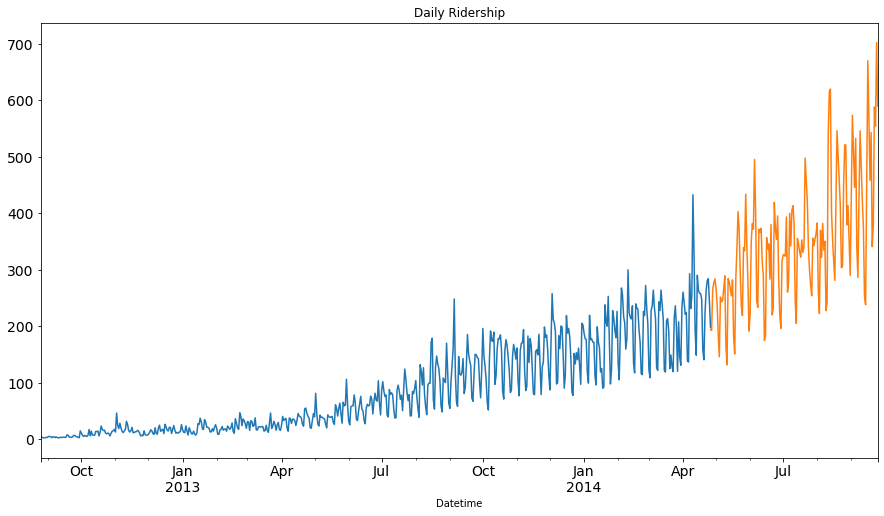

In [4]:
print(len(df))   #打印数据的长度。

#数据集按照0.2来划分，训练集共有14630个数据
train = df[0:14630]
test = df[14630:]

#按照天数显示数据
df.Timestamp = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M')
df.index = df.Timestamp
df = df.resample('D').mean()
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
train.index = train.Timestamp
train = train.resample('D').mean()
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')
test.index = test.Timestamp
test = test.resample('D').mean()

#可视化数据
train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()


2、准备数据

In [7]:
#处理数据，按照look_back天的数据预测下一天的数据
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
look_back = 16   #用前16天的预测后一天的
batch_size = 1
def create_dataset(dataset):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back -1):
        x = dataset[i: i + look_back, 0]
        dataX.append(x)
        y = dataset[i + look_back, 0]
        dataY.append(y)
        print('X:%s ,Y:%s'%(x, y))
    return np.array(dataX), np.array(dataY)
#读取数据 
df = pd.read_csv("jetrail_train.csv", header=None, usecols=[2])
Jet_data =df.values[1:].astype(float)
#最大最小归一化
scaler = MinMaxScaler(feature_range=(-1, 1))
Jet_dataset = scaler.fit_transform(Jet_data)

#划分数据集
train_data = Jet_dataset[0:14630, :]
test_data = Jet_dataset[14630:, :]

#创建dataset
X_train, Y_train = create_dataset(train_data)
X_test, Y_test = create_dataset(test_data)
print(X_train.shape)
print(Y_train.shape)
#转换数据类型为 [样本，时间步长，特征]
X_train = np.reshape(X_train, (X_train.shape[0] , X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_train = np.reshape(Y_train, (1, Y_train.shape[0], 1))
Y_test = np.reshape(Y_test, (Y_test.shape[0]))


X:[-0.99033816 -1.         -0.99355878 -1.         -1.         -1.
 -1.         -1.         -0.99355878 -1.         -1.         -0.99355878
 -0.99677939 -1.         -0.99355878 -1.        ] ,Y:-1.0
X:[-1.         -0.99355878 -1.         -1.         -1.         -1.
 -1.         -0.99355878 -1.         -1.         -0.99355878 -0.99677939
 -1.         -0.99355878 -1.         -1.        ] ,Y:-1.0
X:[-0.99355878 -1.         -1.         -1.         -1.         -1.
 -0.99355878 -1.         -1.         -0.99355878 -0.99677939 -1.
 -0.99355878 -1.         -1.         -1.        ] ,Y:-1.0
X:[-1.         -1.         -1.         -1.         -1.         -0.99355878
 -1.         -1.         -0.99355878 -0.99677939 -1.         -0.99355878
 -1.         -1.         -1.         -1.        ] ,Y:-1.0
X:[-1.         -1.         -1.         -1.         -0.99355878 -1.
 -1.         -0.99355878 -0.99677939 -1.         -0.99355878 -1.
 -1.         -1.         -1.         -1.        ] ,Y:-1.0
X:[-1.         -1.

 -0.99033816 -1.         -1.         -1.        ] ,Y:-1.0
X:[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -0.99355878 -1.         -0.99033816
 -1.         -1.         -1.         -1.        ] ,Y:-1.0
X:[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.99355878 -1.         -0.99033816 -1.
 -1.         -1.         -1.         -1.        ] ,Y:-1.0
X:[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -0.99355878 -1.         -0.99033816 -1.         -1.
 -1.         -1.         -1.         -1.        ] ,Y:-1.0
X:[-1.         -1.         -1.         -1.         -1.         -1.
 -0.99355878 -1.         -0.99033816 -1.         -1.         -1.
 -1.         -1.         -1.         -1.        ] ,Y:-0.9967793880837359
X:[-1.         -1.         -1.         -1.         -1.         -0.99355878
 -1.         -0.99033816 -1.         -1.         -1.         -1.
 -1.         -1.   

 -1.         -0.99677939 -1.         -1.        ] ,Y:-1.0
X:[-1.         -0.99677939 -1.         -0.99677939 -1.         -0.99677939
 -1.         -0.99677939 -1.         -1.         -0.99677939 -1.
 -0.99677939 -1.         -1.         -1.        ] ,Y:-0.9967793880837359
X:[-0.99677939 -1.         -0.99677939 -1.         -0.99677939 -1.
 -0.99677939 -1.         -1.         -0.99677939 -1.         -0.99677939
 -1.         -1.         -1.         -0.99677939] ,Y:-1.0
X:[-1.         -0.99677939 -1.         -0.99677939 -1.         -0.99677939
 -1.         -1.         -0.99677939 -1.         -0.99677939 -1.
 -1.         -1.         -0.99677939 -1.        ] ,Y:-1.0
X:[-0.99677939 -1.         -0.99677939 -1.         -0.99677939 -1.
 -1.         -0.99677939 -1.         -0.99677939 -1.         -1.
 -1.         -0.99677939 -1.         -1.        ] ,Y:-1.0
X:[-1.         -0.99677939 -1.         -0.99677939 -1.         -1.
 -0.99677939 -1.         -0.99677939 -1.         -1.         -1.
 -0.9967793

 -0.98067633 -0.99355878 -0.99355878 -0.9742351 ] ,Y:-0.9388083735909823
X:[-0.99355878 -0.99677939 -0.99033816 -0.99355878 -0.99677939 -0.99355878
 -0.99355878 -0.98389694 -0.99355878 -0.99355878 -0.99355878 -0.98067633
 -0.99355878 -0.99355878 -0.9742351  -0.93880837] ,Y:-0.9645732689210951
X:[-0.99677939 -0.99033816 -0.99355878 -0.99677939 -0.99355878 -0.99355878
 -0.98389694 -0.99355878 -0.99355878 -0.99355878 -0.98067633 -0.99355878
 -0.99355878 -0.9742351  -0.93880837 -0.96457327] ,Y:-0.9774557165861514
X:[-0.99033816 -0.99355878 -0.99677939 -0.99355878 -0.99355878 -0.98389694
 -0.99355878 -0.99355878 -0.99355878 -0.98067633 -0.99355878 -0.99355878
 -0.9742351  -0.93880837 -0.96457327 -0.97745572] ,Y:-0.9838969404186796
X:[-0.99355878 -0.99677939 -0.99355878 -0.99355878 -0.98389694 -0.99355878
 -0.99355878 -0.99355878 -0.98067633 -0.99355878 -0.99355878 -0.9742351
 -0.93880837 -0.96457327 -0.97745572 -0.98389694] ,Y:-0.9871175523349437
X:[-0.99677939 -0.99355878 -0.99355878 -0.98

 -0.98389694 -0.98389694 -0.98389694 -1.        ] ,Y:-0.9903381642512078
X:[-0.96135266 -0.96779388 -0.96457327 -0.96457327 -0.9742351  -0.98067633
 -0.95813205 -0.9742351  -0.98711755 -0.98711755 -0.98711755 -0.98389694
 -0.98389694 -0.98389694 -1.         -0.99033816] ,Y:-0.9774557165861514
X:[-0.96779388 -0.96457327 -0.96457327 -0.9742351  -0.98067633 -0.95813205
 -0.9742351  -0.98711755 -0.98711755 -0.98711755 -0.98389694 -0.98389694
 -0.98389694 -1.         -0.99033816 -0.97745572] ,Y:-0.9710144927536232
X:[-0.96457327 -0.96457327 -0.9742351  -0.98067633 -0.95813205 -0.9742351
 -0.98711755 -0.98711755 -0.98711755 -0.98389694 -0.98389694 -0.98389694
 -1.         -0.99033816 -0.97745572 -0.97101449] ,Y:-0.9742351046698873
X:[-0.96457327 -0.9742351  -0.98067633 -0.95813205 -0.9742351  -0.98711755
 -0.98711755 -0.98711755 -0.98389694 -0.98389694 -0.98389694 -1.
 -0.99033816 -0.97745572 -0.97101449 -0.9742351 ] ,Y:-0.9581320450885669
X:[-0.9742351  -0.98067633 -0.95813205 -0.9742351  -

 -0.98711755 -1.         -0.98711755 -0.98711755] ,Y:-0.9903381642512078
X:[-0.99355878 -0.98711755 -0.99355878 -0.99355878 -0.98711755 -0.99355878
 -0.99677939 -1.         -1.         -0.99355878 -0.99355878 -0.98711755
 -1.         -0.98711755 -0.98711755 -0.99033816] ,Y:-0.9871175523349437
X:[-0.98711755 -0.99355878 -0.99355878 -0.98711755 -0.99355878 -0.99677939
 -1.         -1.         -0.99355878 -0.99355878 -0.98711755 -1.
 -0.98711755 -0.98711755 -0.99033816 -0.98711755] ,Y:-0.9967793880837359
X:[-0.99355878 -0.99355878 -0.98711755 -0.99355878 -0.99677939 -1.
 -1.         -0.99355878 -0.99355878 -0.98711755 -1.         -0.98711755
 -0.98711755 -0.99033816 -0.98711755 -0.99677939] ,Y:-0.9838969404186796
X:[-0.99355878 -0.98711755 -0.99355878 -0.99677939 -1.         -1.
 -0.99355878 -0.99355878 -0.98711755 -1.         -0.98711755 -0.98711755
 -0.99033816 -0.98711755 -0.99677939 -0.98389694] ,Y:-0.9903381642512078
X:[-0.98711755 -0.99355878 -0.99677939 -1.         -1.         -0.9

 -0.98389694 -0.98389694 -0.98711755 -0.98711755] ,Y:-0.9774557165861514
X:[-0.9742351  -0.96779388 -0.9742351  -0.98067633 -0.98389694 -0.99033816
 -0.99355878 -0.99677939 -0.98711755 -0.99355878 -0.98711755 -0.98389694
 -0.98389694 -0.98711755 -0.98711755 -0.97745572] ,Y:-0.9838969404186796
X:[-0.96779388 -0.9742351  -0.98067633 -0.98389694 -0.99033816 -0.99355878
 -0.99677939 -0.98711755 -0.99355878 -0.98711755 -0.98389694 -0.98389694
 -0.98711755 -0.98711755 -0.97745572 -0.98389694] ,Y:-0.9806763285024155
X:[-0.9742351  -0.98067633 -0.98389694 -0.99033816 -0.99355878 -0.99677939
 -0.98711755 -0.99355878 -0.98711755 -0.98389694 -0.98389694 -0.98711755
 -0.98711755 -0.97745572 -0.98389694 -0.98067633] ,Y:-0.9645732689210951
X:[-0.98067633 -0.98389694 -0.99033816 -0.99355878 -0.99677939 -0.98711755
 -0.99355878 -0.98711755 -0.98389694 -0.98389694 -0.98711755 -0.98711755
 -0.97745572 -0.98389694 -0.98067633 -0.96457327] ,Y:-0.9549114331723028
X:[-0.98389694 -0.99033816 -0.99355878 -0.9

 -0.99033816 -0.98067633 -1.         -0.98389694] ,Y:-0.9903381642512078
X:[-0.95813205 -0.96135266 -0.9742351  -0.9194847  -0.94202899 -0.94847021
 -0.96135266 -0.96779388 -0.97101449 -0.93236715 -0.95813205 -0.99033816
 -0.98067633 -1.         -0.98389694 -0.99033816] ,Y:-0.9871175523349437
X:[-0.96135266 -0.9742351  -0.9194847  -0.94202899 -0.94847021 -0.96135266
 -0.96779388 -0.97101449 -0.93236715 -0.95813205 -0.99033816 -0.98067633
 -1.         -0.98389694 -0.99033816 -0.98711755] ,Y:-0.9742351046698873
X:[-0.9742351  -0.9194847  -0.94202899 -0.94847021 -0.96135266 -0.96779388
 -0.97101449 -0.93236715 -0.95813205 -0.99033816 -0.98067633 -1.
 -0.98389694 -0.99033816 -0.98711755 -0.9742351 ] ,Y:-0.9774557165861514
X:[-0.9194847  -0.94202899 -0.94847021 -0.96135266 -0.96779388 -0.97101449
 -0.93236715 -0.95813205 -0.99033816 -0.98067633 -1.         -0.98389694
 -0.99033816 -0.98711755 -0.9742351  -0.97745572] ,Y:-0.9710144927536232
X:[-0.94202899 -0.94847021 -0.96135266 -0.96779388 

 -0.9742351  -0.96135266 -0.99033816 -0.96779388] ,Y:-0.9484702093397746
X:[-0.98067633 -0.96135266 -0.98389694 -0.96135266 -0.9742351  -0.9742351
 -0.97101449 -0.96779388 -0.96135266 -0.97101449 -0.97745572 -0.9742351
 -0.96135266 -0.99033816 -0.96779388 -0.94847021] ,Y:-0.9581320450885669
X:[-0.96135266 -0.98389694 -0.96135266 -0.9742351  -0.9742351  -0.97101449
 -0.96779388 -0.96135266 -0.97101449 -0.97745572 -0.9742351  -0.96135266
 -0.99033816 -0.96779388 -0.94847021 -0.95813205] ,Y:-0.9935587761674718
X:[-0.98389694 -0.96135266 -0.9742351  -0.9742351  -0.97101449 -0.96779388
 -0.96135266 -0.97101449 -0.97745572 -0.9742351  -0.96135266 -0.99033816
 -0.96779388 -0.94847021 -0.95813205 -0.99355878] ,Y:-0.9903381642512078
X:[-0.96135266 -0.9742351  -0.9742351  -0.97101449 -0.96779388 -0.96135266
 -0.97101449 -0.97745572 -0.9742351  -0.96135266 -0.99033816 -0.96779388
 -0.94847021 -0.95813205 -0.99355878 -0.99033816] ,Y:-0.9903381642512078
X:[-0.9742351  -0.9742351  -0.97101449 -0.967

 -0.95491143 -0.98067633 -0.98711755 -0.95169082] ,Y:-0.9581320450885669
X:[-0.96779388 -0.99355878 -0.9742351  -0.98067633 -0.97745572 -0.98067633
 -0.96135266 -0.99355878 -0.98067633 -0.9742351  -0.95813205 -0.95491143
 -0.98067633 -0.98711755 -0.95169082 -0.95813205] ,Y:-0.9935587761674718
X:[-0.99355878 -0.9742351  -0.98067633 -0.97745572 -0.98067633 -0.96135266
 -0.99355878 -0.98067633 -0.9742351  -0.95813205 -0.95491143 -0.98067633
 -0.98711755 -0.95169082 -0.95813205 -0.99355878] ,Y:-0.9581320450885669
X:[-0.9742351  -0.98067633 -0.97745572 -0.98067633 -0.96135266 -0.99355878
 -0.98067633 -0.9742351  -0.95813205 -0.95491143 -0.98067633 -0.98711755
 -0.95169082 -0.95813205 -0.99355878 -0.95813205] ,Y:-0.961352657004831
X:[-0.98067633 -0.97745572 -0.98067633 -0.96135266 -0.99355878 -0.98067633
 -0.9742351  -0.95813205 -0.95491143 -0.98067633 -0.98711755 -0.95169082
 -0.95813205 -0.99355878 -0.95813205 -0.96135266] ,Y:-0.961352657004831
X:[-0.97745572 -0.98067633 -0.96135266 -0.993

 -0.9742351  -0.96135266 -0.95169082 -0.98389694] ,Y:-0.9903381642512078
X:[-0.96779388 -0.95491143 -0.96779388 -0.96135266 -0.95813205 -0.9452496
 -0.95169082 -0.95491143 -0.96135266 -0.98067633 -0.97745572 -0.9742351
 -0.96135266 -0.95169082 -0.98389694 -0.99033816] ,Y:-0.9710144927536232
X:[-0.95491143 -0.96779388 -0.96135266 -0.95813205 -0.9452496  -0.95169082
 -0.95491143 -0.96135266 -0.98067633 -0.97745572 -0.9742351  -0.96135266
 -0.95169082 -0.98389694 -0.99033816 -0.97101449] ,Y:-0.9871175523349437
X:[-0.96779388 -0.96135266 -0.95813205 -0.9452496  -0.95169082 -0.95491143
 -0.96135266 -0.98067633 -0.97745572 -0.9742351  -0.96135266 -0.95169082
 -0.98389694 -0.99033816 -0.97101449 -0.98711755] ,Y:-0.9806763285024155
X:[-0.96135266 -0.95813205 -0.9452496  -0.95169082 -0.95491143 -0.96135266
 -0.98067633 -0.97745572 -0.9742351  -0.96135266 -0.95169082 -0.98389694
 -0.99033816 -0.97101449 -0.98711755 -0.98067633] ,Y:-0.9871175523349437
X:[-0.95813205 -0.9452496  -0.95169082 -0.954

 -0.96135266 -0.97745572 -0.96779388 -0.97745572] ,Y:-0.9516908212560387
X:[-0.95169082 -0.95169082 -0.9742351  -0.91304348 -0.92270531 -0.94202899
 -0.95169082 -0.96779388 -0.95491143 -0.96135266 -0.9742351  -0.96135266
 -0.97745572 -0.96779388 -0.97745572 -0.95169082] ,Y:-0.9484702093397746
X:[-0.95169082 -0.9742351  -0.91304348 -0.92270531 -0.94202899 -0.95169082
 -0.96779388 -0.95491143 -0.96135266 -0.9742351  -0.96135266 -0.97745572
 -0.96779388 -0.97745572 -0.95169082 -0.94847021] ,Y:-0.9581320450885669
X:[-0.9742351  -0.91304348 -0.92270531 -0.94202899 -0.95169082 -0.96779388
 -0.95491143 -0.96135266 -0.9742351  -0.96135266 -0.97745572 -0.96779388
 -0.97745572 -0.95169082 -0.94847021 -0.95813205] ,Y:-0.9388083735909823
X:[-0.91304348 -0.92270531 -0.94202899 -0.95169082 -0.96779388 -0.95491143
 -0.96135266 -0.9742351  -0.96135266 -0.97745572 -0.96779388 -0.97745572
 -0.95169082 -0.94847021 -0.95813205 -0.93880837] ,Y:-0.9420289855072463
X:[-0.92270531 -0.94202899 -0.95169082 -0.9

 -0.95169082 -0.97101449 -0.96135266 -0.96457327] ,Y:-0.9420289855072463
X:[-0.92592593 -0.95491143 -0.93236715 -0.93236715 -0.96779388 -0.96779388
 -0.97101449 -0.98389694 -0.96135266 -0.9742351  -0.96779388 -0.95169082
 -0.97101449 -0.96135266 -0.96457327 -0.94202899] ,Y:-0.9581320450885669
X:[-0.95491143 -0.93236715 -0.93236715 -0.96779388 -0.96779388 -0.97101449
 -0.98389694 -0.96135266 -0.9742351  -0.96779388 -0.95169082 -0.97101449
 -0.96135266 -0.96457327 -0.94202899 -0.95813205] ,Y:-0.9710144927536232
X:[-0.93236715 -0.93236715 -0.96779388 -0.96779388 -0.97101449 -0.98389694
 -0.96135266 -0.9742351  -0.96779388 -0.95169082 -0.97101449 -0.96135266
 -0.96457327 -0.94202899 -0.95813205 -0.97101449] ,Y:-0.9388083735909823
X:[-0.93236715 -0.96779388 -0.96779388 -0.97101449 -0.98389694 -0.96135266
 -0.9742351  -0.96779388 -0.95169082 -0.97101449 -0.96135266 -0.96457327
 -0.94202899 -0.95813205 -0.97101449 -0.93880837] ,Y:-0.9323671497584541
X:[-0.96779388 -0.96779388 -0.97101449 -0.9

 -0.96135266 -0.89371981 -0.90982287 -0.96135266] ,Y:-0.9388083735909823
X:[-0.92592593 -0.90660225 -0.93236715 -0.93236715 -0.9194847  -0.95169082
 -0.9194847  -0.94202899 -0.90982287 -0.93880837 -0.92592593 -0.96135266
 -0.89371981 -0.90982287 -0.96135266 -0.93880837] ,Y:-0.9677938808373591
X:[-0.90660225 -0.93236715 -0.93236715 -0.9194847  -0.95169082 -0.9194847
 -0.94202899 -0.90982287 -0.93880837 -0.92592593 -0.96135266 -0.89371981
 -0.90982287 -0.96135266 -0.93880837 -0.96779388] ,Y:-0.9806763285024155
X:[-0.93236715 -0.93236715 -0.9194847  -0.95169082 -0.9194847  -0.94202899
 -0.90982287 -0.93880837 -0.92592593 -0.96135266 -0.89371981 -0.90982287
 -0.96135266 -0.93880837 -0.96779388 -0.98067633] ,Y:-0.9871175523349437
X:[-0.93236715 -0.9194847  -0.95169082 -0.9194847  -0.94202899 -0.90982287
 -0.93880837 -0.92592593 -0.96135266 -0.89371981 -0.90982287 -0.96135266
 -0.93880837 -0.96779388 -0.98067633 -0.98711755] ,Y:-0.9677938808373591
X:[-0.9194847  -0.95169082 -0.9194847  -0.94

 -0.92592593 -0.91626409 -0.88727858 -0.85507246] ,Y:-0.8647342995169083
X:[-0.82286634 -0.8389694  -0.77455717 -0.86151369 -0.90660225 -0.9452496
 -0.9452496  -0.90660225 -0.97101449 -0.9452496  -0.92914654 -0.92592593
 -0.91626409 -0.88727858 -0.85507246 -0.8647343 ] ,Y:-0.8904991948470209
X:[-0.8389694  -0.77455717 -0.86151369 -0.90660225 -0.9452496  -0.9452496
 -0.90660225 -0.97101449 -0.9452496  -0.92914654 -0.92592593 -0.91626409
 -0.88727858 -0.85507246 -0.8647343  -0.89049919] ,Y:-0.8743961352657005
X:[-0.77455717 -0.86151369 -0.90660225 -0.9452496  -0.9452496  -0.90660225
 -0.97101449 -0.9452496  -0.92914654 -0.92592593 -0.91626409 -0.88727858
 -0.85507246 -0.8647343  -0.89049919 -0.87439614] ,Y:-0.893719806763285
X:[-0.86151369 -0.90660225 -0.9452496  -0.9452496  -0.90660225 -0.97101449
 -0.9452496  -0.92914654 -0.92592593 -0.91626409 -0.88727858 -0.85507246
 -0.8647343  -0.89049919 -0.87439614 -0.89371981] ,Y:-0.9066022544283414
X:[-0.90660225 -0.9452496  -0.9452496  -0.9066

 -0.86795491 -0.87761675 -0.87761675 -0.92270531] ,Y:-0.92914653784219
X:[-0.84219002 -0.89049919 -0.88405797 -0.85185185 -0.86795491 -0.83574879
 -0.91304348 -0.89694042 -0.88083736 -0.85507246 -0.86151369 -0.86795491
 -0.87761675 -0.87761675 -0.92270531 -0.92914654] ,Y:-0.9420289855072463
X:[-0.89049919 -0.88405797 -0.85185185 -0.86795491 -0.83574879 -0.91304348
 -0.89694042 -0.88083736 -0.85507246 -0.86151369 -0.86795491 -0.87761675
 -0.87761675 -0.92270531 -0.92914654 -0.94202899] ,Y:-0.9645732689210951
X:[-0.88405797 -0.85185185 -0.86795491 -0.83574879 -0.91304348 -0.89694042
 -0.88083736 -0.85507246 -0.86151369 -0.86795491 -0.87761675 -0.87761675
 -0.92270531 -0.92914654 -0.94202899 -0.96457327] ,Y:-0.961352657004831
X:[-0.85185185 -0.86795491 -0.83574879 -0.91304348 -0.89694042 -0.88083736
 -0.85507246 -0.86151369 -0.86795491 -0.87761675 -0.87761675 -0.92270531
 -0.92914654 -0.94202899 -0.96457327 -0.96135266] ,Y:-0.9549114331723028
X:[-0.86795491 -0.83574879 -0.91304348 -0.8969

 -0.94847021 -0.94202899 -0.89049919 -0.82608696] ,Y:-0.7230273752012882
X:[-0.91304348 -0.92270531 -0.88727858 -0.90016103 -0.90016103 -0.92270531
 -0.93558776 -0.95169082 -0.97745572 -0.97101449 -0.97101449 -0.94847021
 -0.94202899 -0.89049919 -0.82608696 -0.72302738] ,Y:-0.7616747181964574
X:[-0.92270531 -0.88727858 -0.90016103 -0.90016103 -0.92270531 -0.93558776
 -0.95169082 -0.97745572 -0.97101449 -0.97101449 -0.94847021 -0.94202899
 -0.89049919 -0.82608696 -0.72302738 -0.76167472] ,Y:-0.8454106280193237
X:[-0.88727858 -0.90016103 -0.90016103 -0.92270531 -0.93558776 -0.95169082
 -0.97745572 -0.97101449 -0.97101449 -0.94847021 -0.94202899 -0.89049919
 -0.82608696 -0.72302738 -0.76167472 -0.84541063] ,Y:-0.7713365539452496
X:[-0.90016103 -0.90016103 -0.92270531 -0.93558776 -0.95169082 -0.97745572
 -0.97101449 -0.97101449 -0.94847021 -0.94202899 -0.89049919 -0.82608696
 -0.72302738 -0.76167472 -0.84541063 -0.77133655] ,Y:-0.8260869565217391
X:[-0.90016103 -0.92270531 -0.93558776 -0.9

 -0.93880837 -0.9452496  -0.93558776 -0.96135266] ,Y:-0.9452495974235104
X:[-0.84541063 -0.8099839  -0.86151369 -0.79710145 -0.88405797 -0.87761675
 -0.85829308 -0.89694042 -0.85507246 -0.94847021 -0.9452496  -0.93880837
 -0.9452496  -0.93558776 -0.96135266 -0.9452496 ] ,Y:-0.8840579710144928
X:[-0.8099839  -0.86151369 -0.79710145 -0.88405797 -0.87761675 -0.85829308
 -0.89694042 -0.85507246 -0.94847021 -0.9452496  -0.93880837 -0.9452496
 -0.93558776 -0.96135266 -0.9452496  -0.88405797] ,Y:-0.8679549114331724
X:[-0.86151369 -0.79710145 -0.88405797 -0.87761675 -0.85829308 -0.89694042
 -0.85507246 -0.94847021 -0.9452496  -0.93880837 -0.9452496  -0.93558776
 -0.96135266 -0.9452496  -0.88405797 -0.86795491] ,Y:-0.8293075684380032
X:[-0.79710145 -0.88405797 -0.87761675 -0.85829308 -0.89694042 -0.85507246
 -0.94847021 -0.9452496  -0.93880837 -0.9452496  -0.93558776 -0.96135266
 -0.9452496  -0.88405797 -0.86795491 -0.82930757] ,Y:-0.8003220611916264
X:[-0.88405797 -0.87761675 -0.85829308 -0.89

 -0.77133655 -0.76811594 -0.75523349 -0.76167472] ,Y:-0.7906602254428341
X:[-0.81320451 -0.81320451 -0.90338164 -0.90338164 -0.91304348 -0.88727858
 -0.90338164 -0.85507246 -0.87439614 -0.76167472 -0.7037037  -0.77133655
 -0.76811594 -0.75523349 -0.76167472 -0.79066023] ,Y:-0.713365539452496
X:[-0.81320451 -0.90338164 -0.90338164 -0.91304348 -0.88727858 -0.90338164
 -0.85507246 -0.87439614 -0.76167472 -0.7037037  -0.77133655 -0.76811594
 -0.75523349 -0.76167472 -0.79066023 -0.71336554] ,Y:-0.7326892109500805
X:[-0.90338164 -0.90338164 -0.91304348 -0.88727858 -0.90338164 -0.85507246
 -0.87439614 -0.76167472 -0.7037037  -0.77133655 -0.76811594 -0.75523349
 -0.76167472 -0.79066023 -0.71336554 -0.73268921] ,Y:-0.7938808373590982
X:[-0.90338164 -0.91304348 -0.88727858 -0.90338164 -0.85507246 -0.87439614
 -0.76167472 -0.7037037  -0.77133655 -0.76811594 -0.75523349 -0.76167472
 -0.79066023 -0.71336554 -0.73268921 -0.79388084] ,Y:-0.7874396135265701
X:[-0.91304348 -0.88727858 -0.90338164 -0.85

 -0.93236715 -0.91304348 -0.88727858 -0.84541063] ,Y:-0.8421900161030595
X:[-0.77455717 -0.78099839 -0.79388084 -0.81964573 -0.77133655 -0.80676329
 -0.85507246 -0.8389694  -0.91304348 -0.9452496  -0.93236715 -0.93236715
 -0.91304348 -0.88727858 -0.84541063 -0.84219002] ,Y:-0.8454106280193237
X:[-0.78099839 -0.79388084 -0.81964573 -0.77133655 -0.80676329 -0.85507246
 -0.8389694  -0.91304348 -0.9452496  -0.93236715 -0.93236715 -0.91304348
 -0.88727858 -0.84541063 -0.84219002 -0.84541063] ,Y:-0.713365539452496
X:[-0.79388084 -0.81964573 -0.77133655 -0.80676329 -0.85507246 -0.8389694
 -0.91304348 -0.9452496  -0.93236715 -0.93236715 -0.91304348 -0.88727858
 -0.84541063 -0.84219002 -0.84541063 -0.71336554] ,Y:-0.8389694041867954
X:[-0.81964573 -0.77133655 -0.80676329 -0.85507246 -0.8389694  -0.91304348
 -0.9452496  -0.93236715 -0.93236715 -0.91304348 -0.88727858 -0.84541063
 -0.84219002 -0.84541063 -0.71336554 -0.8389694 ] ,Y:-0.7713365539452496
X:[-0.77133655 -0.80676329 -0.85507246 -0.838

 -0.84863124 -0.80354267 -0.80676329 -0.7294686 ] ,Y:-0.7101449275362319
X:[-0.58132045 -0.51046699 -0.54589372 -0.61674718 -0.73913043 -0.83574879
 -0.84541063 -0.85185185 -0.88727858 -0.86151369 -0.87117552 -0.84863124
 -0.80354267 -0.80676329 -0.7294686  -0.71014493] ,Y:-0.6940418679549114
X:[-0.51046699 -0.54589372 -0.61674718 -0.73913043 -0.83574879 -0.84541063
 -0.85185185 -0.88727858 -0.86151369 -0.87117552 -0.84863124 -0.80354267
 -0.80676329 -0.7294686  -0.71014493 -0.69404187] ,Y:-0.7391304347826086
X:[-0.54589372 -0.61674718 -0.73913043 -0.83574879 -0.84541063 -0.85185185
 -0.88727858 -0.86151369 -0.87117552 -0.84863124 -0.80354267 -0.80676329
 -0.7294686  -0.71014493 -0.69404187 -0.73913043] ,Y:-0.7359098228663445
X:[-0.61674718 -0.73913043 -0.83574879 -0.84541063 -0.85185185 -0.88727858
 -0.86151369 -0.87117552 -0.84863124 -0.80354267 -0.80676329 -0.7294686
 -0.71014493 -0.69404187 -0.73913043 -0.73590982] ,Y:-0.6843800322061192
X:[-0.73913043 -0.83574879 -0.84541063 -0.85

 -0.71980676 -0.74557166 -0.72624799 -0.66183575] ,Y:-0.6264090177133655
X:[-0.88727858 -0.91626409 -0.90016103 -0.88083736 -0.82608696 -0.82286634
 -0.74879227 -0.66505636 -0.63285024 -0.73268921 -0.71336554 -0.71980676
 -0.74557166 -0.72624799 -0.66183575 -0.62640902] ,Y:-0.6940418679549114
X:[-0.91626409 -0.90016103 -0.88083736 -0.82608696 -0.82286634 -0.74879227
 -0.66505636 -0.63285024 -0.73268921 -0.71336554 -0.71980676 -0.74557166
 -0.72624799 -0.66183575 -0.62640902 -0.69404187] ,Y:-0.7648953301127215
X:[-0.90016103 -0.88083736 -0.82608696 -0.82286634 -0.74879227 -0.66505636
 -0.63285024 -0.73268921 -0.71336554 -0.71980676 -0.74557166 -0.72624799
 -0.66183575 -0.62640902 -0.69404187 -0.76489533] ,Y:-0.7262479871175523
X:[-0.88083736 -0.82608696 -0.82286634 -0.74879227 -0.66505636 -0.63285024
 -0.73268921 -0.71336554 -0.71980676 -0.74557166 -0.72624799 -0.66183575
 -0.62640902 -0.69404187 -0.76489533 -0.72624799] ,Y:-0.7326892109500805
X:[-0.82608696 -0.82286634 -0.74879227 -0.6

X:[-0.7037037  -0.68115942 -0.99355878 -1.         -0.99677939 -0.99677939
 -0.79066023 -0.56521739 -0.65539452 -0.70048309 -0.70692432 -0.77777778
 -0.73913043 -0.80032206 -0.89049919 -0.89694042] ,Y:-0.92914653784219
X:[-0.68115942 -0.99355878 -1.         -0.99677939 -0.99677939 -0.79066023
 -0.56521739 -0.65539452 -0.70048309 -0.70692432 -0.77777778 -0.73913043
 -0.80032206 -0.89049919 -0.89694042 -0.92914654] ,Y:-0.893719806763285
X:[-0.99355878 -1.         -0.99677939 -0.99677939 -0.79066023 -0.56521739
 -0.65539452 -0.70048309 -0.70692432 -0.77777778 -0.73913043 -0.80032206
 -0.89049919 -0.89694042 -0.92914654 -0.89371981] ,Y:-0.9001610305958132
X:[-1.         -0.99677939 -0.99677939 -0.79066023 -0.56521739 -0.65539452
 -0.70048309 -0.70692432 -0.77777778 -0.73913043 -0.80032206 -0.89049919
 -0.89694042 -0.92914654 -0.89371981 -0.90016103] ,Y:-0.8518518518518519
X:[-0.99677939 -0.99677939 -0.79066023 -0.56521739 -0.65539452 -0.70048309
 -0.70692432 -0.77777778 -0.73913043 -0.8003

 -0.88083736 -0.87117552 -0.8647343  -0.81964573] ,Y:-0.822866344605475
X:[-0.80676329 -0.82608696 -0.8647343  -0.88727858 -0.90660225 -0.94202899
 -0.93236715 -0.92592593 -0.92592593 -0.89371981 -0.91304348 -0.88083736
 -0.87117552 -0.8647343  -0.81964573 -0.82286634] ,Y:-0.8615136876006442
X:[-0.82608696 -0.8647343  -0.88727858 -0.90660225 -0.94202899 -0.93236715
 -0.92592593 -0.92592593 -0.89371981 -0.91304348 -0.88083736 -0.87117552
 -0.8647343  -0.81964573 -0.82286634 -0.86151369] ,Y:-0.8454106280193237
X:[-0.8647343  -0.88727858 -0.90660225 -0.94202899 -0.93236715 -0.92592593
 -0.92592593 -0.89371981 -0.91304348 -0.88083736 -0.87117552 -0.8647343
 -0.81964573 -0.82286634 -0.86151369 -0.84541063] ,Y:-0.855072463768116
X:[-0.88727858 -0.90660225 -0.94202899 -0.93236715 -0.92592593 -0.92592593
 -0.89371981 -0.91304348 -0.88083736 -0.87117552 -0.8647343  -0.81964573
 -0.82286634 -0.86151369 -0.84541063 -0.85507246] ,Y:-0.8325281803542673
X:[-0.90660225 -0.94202899 -0.93236715 -0.9259

 -0.85185185 -0.89694042 -0.90016103 -0.93558776] ,Y:-0.8872785829307569
X:[-0.63929147 -0.64251208 -0.68760064 -0.69082126 -0.67149758 -0.70692432
 -0.68760064 -0.71658615 -0.71336554 -0.75523349 -0.79066023 -0.85185185
 -0.89694042 -0.90016103 -0.93558776 -0.88727858] ,Y:-0.8711755233494364
X:[-0.64251208 -0.68760064 -0.69082126 -0.67149758 -0.70692432 -0.68760064
 -0.71658615 -0.71336554 -0.75523349 -0.79066023 -0.85185185 -0.89694042
 -0.90016103 -0.93558776 -0.88727858 -0.87117552] ,Y:-0.9098228663446055
X:[-0.68760064 -0.69082126 -0.67149758 -0.70692432 -0.68760064 -0.71658615
 -0.71336554 -0.75523349 -0.79066023 -0.85185185 -0.89694042 -0.90016103
 -0.93558776 -0.88727858 -0.87117552 -0.90982287] ,Y:-0.8389694041867954
X:[-0.69082126 -0.67149758 -0.70692432 -0.68760064 -0.71658615 -0.71336554
 -0.75523349 -0.79066023 -0.85185185 -0.89694042 -0.90016103 -0.93558776
 -0.88727858 -0.87117552 -0.90982287 -0.8389694 ] ,Y:-0.8067632850241546
X:[-0.67149758 -0.70692432 -0.68760064 -0.7

 -0.80354267 -0.81964573 -0.88083736 -0.92914654] ,Y:-0.9162640901771337
X:[-0.784219   -0.77777778 -0.77777778 -0.76167472 -0.75201288 -0.75845411
 -0.79710145 -0.81964573 -0.74879227 -0.7294686  -0.77455717 -0.80354267
 -0.81964573 -0.88083736 -0.92914654 -0.91626409] ,Y:-0.9066022544283414
X:[-0.77777778 -0.77777778 -0.76167472 -0.75201288 -0.75845411 -0.79710145
 -0.81964573 -0.74879227 -0.7294686  -0.77455717 -0.80354267 -0.81964573
 -0.88083736 -0.92914654 -0.91626409 -0.90660225] ,Y:-0.9098228663446055
X:[-0.77777778 -0.76167472 -0.75201288 -0.75845411 -0.79710145 -0.81964573
 -0.74879227 -0.7294686  -0.77455717 -0.80354267 -0.81964573 -0.88083736
 -0.92914654 -0.91626409 -0.90660225 -0.90982287] ,Y:-0.8711755233494364
X:[-0.76167472 -0.75201288 -0.75845411 -0.79710145 -0.81964573 -0.74879227
 -0.7294686  -0.77455717 -0.80354267 -0.81964573 -0.88083736 -0.92914654
 -0.91626409 -0.90660225 -0.90982287 -0.87117552] ,Y:-0.8582930756843801
X:[-0.75201288 -0.75845411 -0.79710145 -0.8

 -0.70692432 -0.73268921 -0.73268921 -0.84541063] ,Y:-0.8776167471819646
X:[-0.58776167 -0.59098229 -0.61030596 -0.55555556 -0.61352657 -0.60708535
 -0.51046699 -0.52012882 -0.66827697 -0.63929147 -0.72302738 -0.70692432
 -0.73268921 -0.73268921 -0.84541063 -0.87761675] ,Y:-0.8196457326892109
X:[-0.59098229 -0.61030596 -0.55555556 -0.61352657 -0.60708535 -0.51046699
 -0.52012882 -0.66827697 -0.63929147 -0.72302738 -0.70692432 -0.73268921
 -0.73268921 -0.84541063 -0.87761675 -0.81964573] ,Y:-0.7809983896940419
X:[-0.61030596 -0.55555556 -0.61352657 -0.60708535 -0.51046699 -0.52012882
 -0.66827697 -0.63929147 -0.72302738 -0.70692432 -0.73268921 -0.73268921
 -0.84541063 -0.87761675 -0.81964573 -0.78099839] ,Y:-0.784219001610306
X:[-0.55555556 -0.61352657 -0.60708535 -0.51046699 -0.52012882 -0.66827697
 -0.63929147 -0.72302738 -0.70692432 -0.73268921 -0.73268921 -0.84541063
 -0.87761675 -0.81964573 -0.78099839 -0.784219  ] ,Y:-0.713365539452496
X:[-0.61352657 -0.60708535 -0.51046699 -0.520

X:[-0.66505636 -0.58454106 -0.60386473 -0.63929147 -0.54589372 -0.52979066
 -0.51046699 -0.59098229 -0.60708535 -0.61030596 -0.39130435 -0.57487923
 -0.48148148 -0.59098229 -0.63285024 -0.79066023] ,Y:-0.8003220611916264
X:[-0.58454106 -0.60386473 -0.63929147 -0.54589372 -0.52979066 -0.51046699
 -0.59098229 -0.60708535 -0.61030596 -0.39130435 -0.57487923 -0.48148148
 -0.59098229 -0.63285024 -0.79066023 -0.80032206] ,Y:-0.8164251207729469
X:[-0.60386473 -0.63929147 -0.54589372 -0.52979066 -0.51046699 -0.59098229
 -0.60708535 -0.61030596 -0.39130435 -0.57487923 -0.48148148 -0.59098229
 -0.63285024 -0.79066023 -0.80032206 -0.81642512] ,Y:-0.7809983896940419
X:[-0.63929147 -0.54589372 -0.52979066 -0.51046699 -0.59098229 -0.60708535
 -0.61030596 -0.39130435 -0.57487923 -0.48148148 -0.59098229 -0.63285024
 -0.79066023 -0.80032206 -0.81642512 -0.78099839] ,Y:-0.8357487922705314
X:[-0.54589372 -0.52979066 -0.51046699 -0.59098229 -0.60708535 -0.61030596
 -0.39130435 -0.57487923 -0.48148148 -0.5

X:[-0.85507246 -0.88727858 -0.79710145 -0.79710145 -0.81964573 -0.81642512
 -0.84219002 -0.74557166 -0.81320451 -0.79388084 -0.81320451 -0.7294686
 -0.75201288 -0.80354267 -0.77455717 -0.73590982] ,Y:-0.7681159420289856
X:[-0.88727858 -0.79710145 -0.79710145 -0.81964573 -0.81642512 -0.84219002
 -0.74557166 -0.81320451 -0.79388084 -0.81320451 -0.7294686  -0.75201288
 -0.80354267 -0.77455717 -0.73590982 -0.76811594] ,Y:-0.8615136876006442
X:[-0.79710145 -0.79710145 -0.81964573 -0.81642512 -0.84219002 -0.74557166
 -0.81320451 -0.79388084 -0.81320451 -0.7294686  -0.75201288 -0.80354267
 -0.77455717 -0.73590982 -0.76811594 -0.86151369] ,Y:-0.8904991948470209
X:[-0.79710145 -0.81964573 -0.81642512 -0.84219002 -0.74557166 -0.81320451
 -0.79388084 -0.81320451 -0.7294686  -0.75201288 -0.80354267 -0.77455717
 -0.73590982 -0.76811594 -0.86151369 -0.89049919] ,Y:-0.8615136876006442
X:[-0.81964573 -0.81642512 -0.84219002 -0.74557166 -0.81320451 -0.79388084
 -0.81320451 -0.7294686  -0.75201288 -0.80

 -0.79710145 -0.88405797 -0.85829308 -0.8389694 ] ,Y:-0.7906602254428341
X:[-0.47826087 -0.44927536 -0.57487923 -0.52012882 -0.56199678 -0.49114332
 -0.52979066 -0.55877617 -0.6747182  -0.76811594 -0.81964573 -0.79710145
 -0.88405797 -0.85829308 -0.8389694  -0.79066023] ,Y:-0.7520128824476651
X:[-0.44927536 -0.57487923 -0.52012882 -0.56199678 -0.49114332 -0.52979066
 -0.55877617 -0.6747182  -0.76811594 -0.81964573 -0.79710145 -0.88405797
 -0.85829308 -0.8389694  -0.79066023 -0.75201288] ,Y:-0.6714975845410629
X:[-0.57487923 -0.52012882 -0.56199678 -0.49114332 -0.52979066 -0.55877617
 -0.6747182  -0.76811594 -0.81964573 -0.79710145 -0.88405797 -0.85829308
 -0.8389694  -0.79066023 -0.75201288 -0.67149758] ,Y:-0.4814814814814815
X:[-0.52012882 -0.56199678 -0.49114332 -0.52979066 -0.55877617 -0.6747182
 -0.76811594 -0.81964573 -0.79710145 -0.88405797 -0.85829308 -0.8389694
 -0.79066023 -0.75201288 -0.67149758 -0.48148148] ,Y:-0.5394524959742351
X:[-0.56199678 -0.49114332 -0.52979066 -0.558

X:[-0.6747182  -0.72624799 -0.70692432 -0.80354267 -0.69726248 -0.63285024
 -0.62318841 -0.71014493 -0.66183575 -0.66183575 -0.67793881 -0.75523349
 -0.84219002 -0.61030596 -0.79388084 -0.81320451] ,Y:-0.8421900161030595
X:[-0.72624799 -0.70692432 -0.80354267 -0.69726248 -0.63285024 -0.62318841
 -0.71014493 -0.66183575 -0.66183575 -0.67793881 -0.75523349 -0.84219002
 -0.61030596 -0.79388084 -0.81320451 -0.84219002] ,Y:-0.8260869565217391
X:[-0.70692432 -0.80354267 -0.69726248 -0.63285024 -0.62318841 -0.71014493
 -0.66183575 -0.66183575 -0.67793881 -0.75523349 -0.84219002 -0.61030596
 -0.79388084 -0.81320451 -0.84219002 -0.82608696] ,Y:-0.7809983896940419
X:[-0.80354267 -0.69726248 -0.63285024 -0.62318841 -0.71014493 -0.66183575
 -0.66183575 -0.67793881 -0.75523349 -0.84219002 -0.61030596 -0.79388084
 -0.81320451 -0.84219002 -0.82608696 -0.78099839] ,Y:-0.8389694041867954
X:[-0.69726248 -0.63285024 -0.62318841 -0.71014493 -0.66183575 -0.66183575
 -0.67793881 -0.75523349 -0.84219002 -0.6

X:[-0.70048309 -0.80354267 -0.77133655 -0.78099839 -0.75845411 -0.68438003
 -0.47504026 -0.33333333 -0.30112721 -0.33655395 -0.16908213 -0.32045089
 -0.40096618 -0.37520129 -0.33333333 -0.13365539] ,Y:-0.1465378421900161
X:[-0.80354267 -0.77133655 -0.78099839 -0.75845411 -0.68438003 -0.47504026
 -0.33333333 -0.30112721 -0.33655395 -0.16908213 -0.32045089 -0.40096618
 -0.37520129 -0.33333333 -0.13365539 -0.14653784] ,Y:-0.23349436392914658
X:[-0.77133655 -0.78099839 -0.75845411 -0.68438003 -0.47504026 -0.33333333
 -0.30112721 -0.33655395 -0.16908213 -0.32045089 -0.40096618 -0.37520129
 -0.33333333 -0.13365539 -0.14653784 -0.23349436] ,Y:-0.3655394524959743
X:[-0.78099839 -0.75845411 -0.68438003 -0.47504026 -0.33333333 -0.30112721
 -0.33655395 -0.16908213 -0.32045089 -0.40096618 -0.37520129 -0.33333333
 -0.13365539 -0.14653784 -0.23349436 -0.36553945] ,Y:-0.31723027375201285
X:[-0.75845411 -0.68438003 -0.47504026 -0.33333333 -0.30112721 -0.33655395
 -0.16908213 -0.32045089 -0.40096618 -0

 -0.16908213 -0.15942029 -0.3784219  -0.19806763] ,Y:-0.20450885668276975
X:[-0.3784219  -0.47826087 -0.50724638 -0.65539452 -0.71980676 -0.7294686
 -0.69726248 -0.69404187 -0.63929147 -0.58132045 -0.10144928 -0.16908213
 -0.15942029 -0.3784219  -0.19806763 -0.20450886] ,Y:-0.22383252818035426
X:[-0.47826087 -0.50724638 -0.65539452 -0.71980676 -0.7294686  -0.69726248
 -0.69404187 -0.63929147 -0.58132045 -0.10144928 -0.16908213 -0.15942029
 -0.3784219  -0.19806763 -0.20450886 -0.22383253] ,Y:-0.21417069243156206
X:[-0.50724638 -0.65539452 -0.71980676 -0.7294686  -0.69726248 -0.69404187
 -0.63929147 -0.58132045 -0.10144928 -0.16908213 -0.15942029 -0.3784219
 -0.19806763 -0.20450886 -0.22383253 -0.21417069] ,Y:-0.2946859903381642
X:[-0.65539452 -0.71980676 -0.7294686  -0.69726248 -0.69404187 -0.63929147
 -0.58132045 -0.10144928 -0.16908213 -0.15942029 -0.3784219  -0.19806763
 -0.20450886 -0.22383253 -0.21417069 -0.29468599] ,Y:-0.2818035426731079
X:[-0.71980676 -0.7294686  -0.69726248 -0.

 -0.76489533 -0.76167472 -0.79066023 -0.79066023] ,Y:-0.7423510466988728
X:[-0.26570048 -0.2689211  -0.42995169 -0.08856683 -0.2173913  -0.36876006
 -0.47181965 -0.35587762 -0.48792271 -0.63929147 -0.64573269 -0.76489533
 -0.76167472 -0.79066023 -0.79066023 -0.74235105] ,Y:-0.6972624798711755
X:[-0.2689211  -0.42995169 -0.08856683 -0.2173913  -0.36876006 -0.47181965
 -0.35587762 -0.48792271 -0.63929147 -0.64573269 -0.76489533 -0.76167472
 -0.79066023 -0.79066023 -0.74235105 -0.69726248] ,Y:-0.5909822866344605
X:[-0.42995169 -0.08856683 -0.2173913  -0.36876006 -0.47181965 -0.35587762
 -0.48792271 -0.63929147 -0.64573269 -0.76489533 -0.76167472 -0.79066023
 -0.79066023 -0.74235105 -0.69726248 -0.59098229] ,Y:-0.4879227053140097
X:[-0.08856683 -0.2173913  -0.36876006 -0.47181965 -0.35587762 -0.48792271
 -0.63929147 -0.64573269 -0.76489533 -0.76167472 -0.79066023 -0.79066023
 -0.74235105 -0.69726248 -0.59098229 -0.48792271] ,Y:-0.43639291465378427
X:[-0.2173913  -0.36876006 -0.47181965 -0.

 -0.26247987 -0.35909823 -0.25281804 -0.3236715 ] ,Y:-0.3816425120772947
X:[-0.66183575 -0.68760064 -0.61352657 -0.46215781 -0.24959742 -0.21095008
 -0.28824477 -0.40740741 -0.27214171 -0.21095008 -0.35587762 -0.26247987
 -0.35909823 -0.25281804 -0.3236715  -0.38164251] ,Y:-0.3913043478260869
X:[-0.68760064 -0.61352657 -0.46215781 -0.24959742 -0.21095008 -0.28824477
 -0.40740741 -0.27214171 -0.21095008 -0.35587762 -0.26247987 -0.35909823
 -0.25281804 -0.3236715  -0.38164251 -0.39130435] ,Y:-0.5169082125603865
X:[-0.61352657 -0.46215781 -0.24959742 -0.21095008 -0.28824477 -0.40740741
 -0.27214171 -0.21095008 -0.35587762 -0.26247987 -0.35909823 -0.25281804
 -0.3236715  -0.38164251 -0.39130435 -0.51690821] ,Y:-0.4879227053140097
X:[-0.46215781 -0.24959742 -0.21095008 -0.28824477 -0.40740741 -0.27214171
 -0.21095008 -0.35587762 -0.26247987 -0.35909823 -0.25281804 -0.3236715
 -0.38164251 -0.39130435 -0.51690821 -0.48792271] ,Y:-0.6199677938808374
X:[-0.24959742 -0.21095008 -0.28824477 -0.40

 -0.00483092  0.05958132 -0.08534622 -0.34621578] ,Y:-0.42351046698872785
X:[ 0.50080515  0.42351047  0.25281804  0.40740741  0.19806763  0.0273752
  0.06602254  0.16586151  0.16586151  0.02415459  0.00161031 -0.00483092
  0.05958132 -0.08534622 -0.34621578 -0.42351047] ,Y:-0.6038647342995169
X:[ 0.42351047  0.25281804  0.40740741  0.19806763  0.0273752   0.06602254
  0.16586151  0.16586151  0.02415459  0.00161031 -0.00483092  0.05958132
 -0.08534622 -0.34621578 -0.42351047 -0.60386473] ,Y:-0.6682769726247988
X:[ 0.25281804  0.40740741  0.19806763  0.0273752   0.06602254  0.16586151
  0.16586151  0.02415459  0.00161031 -0.00483092  0.05958132 -0.08534622
 -0.34621578 -0.42351047 -0.60386473 -0.66827697] ,Y:-0.7165861513687601
X:[ 0.40740741  0.19806763  0.0273752   0.06602254  0.16586151  0.16586151
  0.02415459  0.00161031 -0.00483092  0.05958132 -0.08534622 -0.34621578
 -0.42351047 -0.60386473 -0.66827697 -0.71658615] ,Y:-0.6811594202898551
X:[ 0.19806763  0.0273752   0.06602254  0.1

 -0.66505636 -0.59742351 -0.71336554 -0.5394525 ] ,Y:-0.5394524959742351
X:[-0.19162641 -0.20450886 -0.24959742 -0.30112721 -0.35909823 -0.11755233
  0.15942029 -0.10466989 -0.39452496 -0.49436393 -0.61030596 -0.66505636
 -0.59742351 -0.71336554 -0.5394525  -0.5394525 ] ,Y:-0.394524959742351
X:[-0.20450886 -0.24959742 -0.30112721 -0.35909823 -0.11755233  0.15942029
 -0.10466989 -0.39452496 -0.49436393 -0.61030596 -0.66505636 -0.59742351
 -0.71336554 -0.5394525  -0.5394525  -0.39452496] ,Y:-0.28824476650563613
X:[-0.24959742 -0.30112721 -0.35909823 -0.11755233  0.15942029 -0.10466989
 -0.39452496 -0.49436393 -0.61030596 -0.66505636 -0.59742351 -0.71336554
 -0.5394525  -0.5394525  -0.39452496 -0.28824477] ,Y:-0.31400966183574885
X:[-0.30112721 -0.35909823 -0.11755233  0.15942029 -0.10466989 -0.39452496
 -0.49436393 -0.61030596 -0.66505636 -0.59742351 -0.71336554 -0.5394525
 -0.5394525  -0.39452496 -0.28824477 -0.31400966] ,Y:-0.30756843800322065
X:[-0.35909823 -0.11755233  0.15942029 -0.

X:[-0.1884058  -0.26247987 -0.16908213 -0.34299517 -0.42028986 -0.54589372
 -0.33333333 -0.50402576 -0.42028986 -0.33655395 -0.41706924 -0.46859903
 -0.34943639 -0.37520129 -0.31723027 -0.5394525 ] ,Y:-0.6360708534621577
X:[-0.26247987 -0.16908213 -0.34299517 -0.42028986 -0.54589372 -0.33333333
 -0.50402576 -0.42028986 -0.33655395 -0.41706924 -0.46859903 -0.34943639
 -0.37520129 -0.31723027 -0.5394525  -0.63607085] ,Y:-0.6972624798711755
X:[-0.16908213 -0.34299517 -0.42028986 -0.54589372 -0.33333333 -0.50402576
 -0.42028986 -0.33655395 -0.41706924 -0.46859903 -0.34943639 -0.37520129
 -0.31723027 -0.5394525  -0.63607085 -0.69726248] ,Y:-0.7906602254428341
X:[-0.34299517 -0.42028986 -0.54589372 -0.33333333 -0.50402576 -0.42028986
 -0.33655395 -0.41706924 -0.46859903 -0.34943639 -0.37520129 -0.31723027
 -0.5394525  -0.63607085 -0.69726248 -0.79066023] ,Y:-0.7809983896940419
X:[-0.42028986 -0.54589372 -0.33333333 -0.50402576 -0.42028986 -0.33655395
 -0.41706924 -0.46859903 -0.34943639 -0.3

3、模型搭建

In [8]:
from torch import nn
class lstm(nn.Module):
    def __init__(self, input_size=1, hidden_size=64 , num_layers=1 , output_size=1 , dropout=0, batch_first=True):  # #定义网络参数，输入维度为1，隐层为64，层数为1，输出维度为1
        super(lstm, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.dropout = dropout
        self.batch_first = batch_first
        self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=self.batch_first, dropout=self.dropout )
        self.linear = nn.Linear(self.hidden_size, self.output_size)
    def forward(self, x):
        out, (hidden, cell) = self.rnn(x)  # x.shape : batch, seq_len, hidden_size , hn.shape and cn.shape : num_layes * direction_numbers, batch, hidden_size
        out = self.linear(hidden)
        return out


4、训练模型与结果显示

In [9]:
#导入需要的包
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset

look_back = 16   #用前16天的预测后一天的
batch_size = 1
#定义数据集函数
def create_dataset(dataset):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back -1):
        x = dataset[i: i + look_back, 0]
        dataX.append(x)
        y = dataset[i + look_back, 0]
        dataY.append(y)
        print('X:%s ,Y:%s'%(x, y))
    return np.array(dataX), np.array(dataY)

#读取数据
df = pd.read_csv("jetrail_train.csv", header=None, usecols=[2])
Jet_data =df.values[1:].astype(float)
#最大最小归一化
scaler = MinMaxScaler(feature_range=(-1, 1))
Jet_dataset = scaler.fit_transform(Jet_data)

#划分数据集
train_data = Jet_dataset[0:14630, :]
test_data = Jet_dataset[14630:, :]

#创建dataset
X_train, Y_train = create_dataset(train_data)
X_test, Y_test = create_dataset(test_data)
print(X_train.shape)
print(Y_train.shape)

#转换数据类型为 [样本，时间步长，特征]
X_train = np.reshape(X_train, (X_train.shape[0] , X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_train = np.reshape(Y_train, (1, Y_train.shape[0], 1))
Y_test = np.reshape(Y_test, (Y_test.shape[0]))

#使用GPU加速训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.from_numpy(X_train)
y = torch.from_numpy(Y_train)
x1 = torch.from_numpy(X_test)
print(X_train.shape)
print(x.shape)

#定义模型
class lstm(nn.Module):
    def __init__(self, input_size=1, hidden_size=64 , num_layers=1 , output_size=1 , dropout=0, batch_first=True):  #定义网络参数，输入维度为1，隐层为64，层数为1，输出维度为1
        super(lstm, self).__init__()
        # lstm的输入 #batch,seq_len, input_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.dropout = dropout
        self.batch_first = batch_first
        self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=self.batch_first, dropout=self.dropout )
        self.linear = nn.Linear(self.hidden_size, self.output_size)
    def forward(self, x):           #前馈传播
        out, (hidden, cell) = self.rnn(x)  
        out = self.linear(hidden)
        return out
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = lstm().to(device)
 
#定义损失函数和优化器，损失函数选用MSE，优化器选用Adam，初始学习率为0.001
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

#训练模型，训练轮数为1500
epochs = 1500
for i in range(epochs):
    inputs = Variable(x)
    pred = model(inputs.float().to(device))
    label = Variable(y).float()
    loss = loss_function(pred, label.float().to(device)) #MSE损失
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()   #梯度清零
    print(f'epoch: {i:3} loss: {loss.item():10.8f}')   #输出损失
torch.save(model, 'JetRail.pth')   #保存模型
#yuce
#model = torch.load('JetRail.pth')
model = model.eval()
predictions = model(x1.float().to(device))
print(predictions.shape)
pre = predictions.detach().cpu().numpy()   #预测
print(pre.shape)

#将预测数据和真实数据反归一化显示真实结果
actual_predictions = scaler.inverse_transform(np.array(pre).reshape(-1, 1))
actual_test = scaler.inverse_transform(np.array(Y_test).reshape(-1, 1))
print(actual_test)
print(actual_predictions)

#可视化显示结果
plt.figure(figsize=(14,8))
plt.title('JetRail prediction')
plt.ylabel('Count')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(actual_test,color = 'red', label='Real Count')
plt.plot(actual_predictions, color = 'blue', label = 'Prediction Count')
plt.legend()
plt.savefig('JetRail-LSTM.png')  #将结果保存
plt.show()


X:[-0.99033816 -1.         -0.99355878 -1.         -1.         -1.
 -1.         -1.         -0.99355878 -1.         -1.         -0.99355878
 -0.99677939 -1.         -0.99355878 -1.        ] ,Y:-1.0
X:[-1.         -0.99355878 -1.         -1.         -1.         -1.
 -1.         -0.99355878 -1.         -1.         -0.99355878 -0.99677939
 -1.         -0.99355878 -1.         -1.        ] ,Y:-1.0
X:[-0.99355878 -1.         -1.         -1.         -1.         -1.
 -0.99355878 -1.         -1.         -0.99355878 -0.99677939 -1.
 -0.99355878 -1.         -1.         -1.        ] ,Y:-1.0
X:[-1.         -1.         -1.         -1.         -1.         -0.99355878
 -1.         -1.         -0.99355878 -0.99677939 -1.         -0.99355878
 -1.         -1.         -1.         -1.        ] ,Y:-1.0
X:[-1.         -1.         -1.         -1.         -0.99355878 -1.
 -1.         -0.99355878 -0.99677939 -1.         -0.99355878 -1.
 -1.         -1.         -1.         -1.        ] ,Y:-1.0
X:[-1.         -1.

 -1.         -0.99677939 -0.99677939 -1.        ] ,Y:-0.9935587761674718
X:[-1.         -0.99677939 -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -0.99677939 -1.
 -0.99677939 -0.99677939 -1.         -0.99355878] ,Y:-0.9935587761674718
X:[-0.99677939 -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -0.99677939 -1.         -0.99677939
 -0.99677939 -1.         -0.99355878 -0.99355878] ,Y:-0.9935587761674718
X:[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -0.99677939 -1.         -0.99677939 -0.99677939
 -1.         -0.99355878 -0.99355878 -0.99355878] ,Y:-0.9903381642512078
X:[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -0.99677939 -1.         -0.99677939 -0.99677939 -1.
 -0.99355878 -0.99355878 -0.99355878 -0.99033816] ,Y:-1.0
X:[-1.         -1.         -1.         -1.         -1.         -1.
 -0.99677939 -1.         -0.99677939 -0

 -1.         -0.99355878 -1.         -0.99355878] ,Y:-0.9967793880837359
X:[-0.99355878 -0.99355878 -0.99355878 -0.96457327 -0.99677939 -1.
 -0.98389694 -0.98389694 -0.97745572 -0.99677939 -1.         -1.
 -0.99355878 -1.         -0.99355878 -0.99677939] ,Y:-1.0
X:[-0.99355878 -0.99355878 -0.96457327 -0.99677939 -1.         -0.98389694
 -0.98389694 -0.97745572 -0.99677939 -1.         -1.         -0.99355878
 -1.         -0.99355878 -0.99677939 -1.        ] ,Y:-1.0
X:[-0.99355878 -0.96457327 -0.99677939 -1.         -0.98389694 -0.98389694
 -0.97745572 -0.99677939 -1.         -1.         -0.99355878 -1.
 -0.99355878 -0.99677939 -1.         -1.        ] ,Y:-0.9903381642512078
X:[-0.96457327 -0.99677939 -1.         -0.98389694 -0.98389694 -0.97745572
 -0.99677939 -1.         -1.         -0.99355878 -1.         -0.99355878
 -0.99677939 -1.         -1.         -0.99033816] ,Y:-1.0
X:[-0.99677939 -1.         -0.98389694 -0.98389694 -0.97745572 -0.99677939
 -1.         -1.         -0.99355878 

 -0.96135266 -0.97745572 -0.96457327 -0.98067633] ,Y:-0.9838969404186796
X:[-0.98711755 -0.9742351  -0.9742351  -0.99033816 -0.96457327 -0.97745572
 -0.93558776 -0.90982287 -0.95169082 -0.95813205 -0.94202899 -0.96135266
 -0.97745572 -0.96457327 -0.98067633 -0.98389694] ,Y:-0.9967793880837359
X:[-0.9742351  -0.9742351  -0.99033816 -0.96457327 -0.97745572 -0.93558776
 -0.90982287 -0.95169082 -0.95813205 -0.94202899 -0.96135266 -0.97745572
 -0.96457327 -0.98067633 -0.98389694 -0.99677939] ,Y:-0.9871175523349437
X:[-0.9742351  -0.99033816 -0.96457327 -0.97745572 -0.93558776 -0.90982287
 -0.95169082 -0.95813205 -0.94202899 -0.96135266 -0.97745572 -0.96457327
 -0.98067633 -0.98389694 -0.99677939 -0.98711755] ,Y:-0.9838969404186796
X:[-0.99033816 -0.96457327 -0.97745572 -0.93558776 -0.90982287 -0.95169082
 -0.95813205 -0.94202899 -0.96135266 -0.97745572 -0.96457327 -0.98067633
 -0.98389694 -0.99677939 -0.98711755 -0.98389694] ,Y:-0.9645732689210951
X:[-0.96457327 -0.97745572 -0.93558776 -0.9

 -1.         -1.         -1.         -0.99677939] ,Y:-1.0
X:[-0.98389694 -0.97101449 -0.98389694 -0.98389694 -0.99033816 -0.98067633
 -0.99677939 -0.99677939 -0.99033816 -0.99033816 -0.99355878 -1.
 -1.         -1.         -0.99677939 -1.        ] ,Y:-1.0
X:[-0.97101449 -0.98389694 -0.98389694 -0.99033816 -0.98067633 -0.99677939
 -0.99677939 -0.99033816 -0.99033816 -0.99355878 -1.         -1.
 -1.         -0.99677939 -1.         -1.        ] ,Y:-0.9903381642512078
X:[-0.98389694 -0.98389694 -0.99033816 -0.98067633 -0.99677939 -0.99677939
 -0.99033816 -0.99033816 -0.99355878 -1.         -1.         -1.
 -0.99677939 -1.         -1.         -0.99033816] ,Y:-0.9871175523349437
X:[-0.98389694 -0.99033816 -0.98067633 -0.99677939 -0.99677939 -0.99033816
 -0.99033816 -0.99355878 -1.         -1.         -1.         -0.99677939
 -1.         -1.         -0.99033816 -0.98711755] ,Y:-0.9935587761674718
X:[-0.99033816 -0.98067633 -0.99677939 -0.99677939 -0.99033816 -0.99033816
 -0.99355878 -1.      

 -0.9742351  -0.94202899 -0.98067633 -0.96457327] ,Y:-0.9774557165861514
X:[-0.95813205 -0.94847021 -0.98067633 -0.97101449 -0.98711755 -0.97101449
 -0.96779388 -0.96457327 -0.96779388 -0.95813205 -0.97101449 -0.9742351
 -0.94202899 -0.98067633 -0.96457327 -0.97745572] ,Y:-0.961352657004831
X:[-0.94847021 -0.98067633 -0.97101449 -0.98711755 -0.97101449 -0.96779388
 -0.96457327 -0.96779388 -0.95813205 -0.97101449 -0.9742351  -0.94202899
 -0.98067633 -0.96457327 -0.97745572 -0.96135266] ,Y:-0.9677938808373591
X:[-0.98067633 -0.97101449 -0.98711755 -0.97101449 -0.96779388 -0.96457327
 -0.96779388 -0.95813205 -0.97101449 -0.9742351  -0.94202899 -0.98067633
 -0.96457327 -0.97745572 -0.96135266 -0.96779388] ,Y:-0.9838969404186796
X:[-0.97101449 -0.98711755 -0.97101449 -0.96779388 -0.96457327 -0.96779388
 -0.95813205 -0.97101449 -0.9742351  -0.94202899 -0.98067633 -0.96457327
 -0.97745572 -0.96135266 -0.96779388 -0.98389694] ,Y:-0.9581320450885669
X:[-0.98711755 -0.97101449 -0.96779388 -0.964

 -0.99033816 -0.99677939 -0.98711755 -0.97101449] ,Y:-0.9935587761674718
X:[-0.96779388 -0.99033816 -0.99033816 -0.98711755 -0.98389694 -0.98711755
 -0.99677939 -0.99033816 -0.99677939 -0.98389694 -0.98067633 -0.99033816
 -0.99677939 -0.98711755 -0.97101449 -0.99355878] ,Y:-0.9871175523349437
X:[-0.99033816 -0.99033816 -0.98711755 -0.98389694 -0.98711755 -0.99677939
 -0.99033816 -0.99677939 -0.98389694 -0.98067633 -0.99033816 -0.99677939
 -0.98711755 -0.97101449 -0.99355878 -0.98711755] ,Y:-0.9903381642512078
X:[-0.99033816 -0.98711755 -0.98389694 -0.98711755 -0.99677939 -0.99033816
 -0.99677939 -0.98389694 -0.98067633 -0.99033816 -0.99677939 -0.98711755
 -0.97101449 -0.99355878 -0.98711755 -0.99033816] ,Y:-0.9838969404186796
X:[-0.98711755 -0.98389694 -0.98711755 -0.99677939 -0.99033816 -0.99677939
 -0.98389694 -0.98067633 -0.99033816 -0.99677939 -0.98711755 -0.97101449
 -0.99355878 -0.98711755 -0.99033816 -0.98389694] ,Y:-0.9935587761674718
X:[-0.98389694 -0.98711755 -0.99677939 -0.9

 -0.99355878 -0.99355878 -0.98389694 -0.98389694] ,Y:-0.9967793880837359
X:[-0.98067633 -0.97101449 -0.98389694 -0.98389694 -0.96779388 -0.9742351
 -0.99355878 -0.99033816 -0.99355878 -0.99033816 -0.99677939 -0.99355878
 -0.99355878 -0.98389694 -0.98389694 -0.99677939] ,Y:-0.9871175523349437
X:[-0.97101449 -0.98389694 -0.98389694 -0.96779388 -0.9742351  -0.99355878
 -0.99033816 -0.99355878 -0.99033816 -0.99677939 -0.99355878 -0.99355878
 -0.98389694 -0.98389694 -0.99677939 -0.98711755] ,Y:-0.9903381642512078
X:[-0.98389694 -0.98389694 -0.96779388 -0.9742351  -0.99355878 -0.99033816
 -0.99355878 -0.99033816 -0.99677939 -0.99355878 -0.99355878 -0.98389694
 -0.98389694 -0.99677939 -0.98711755 -0.99033816] ,Y:-0.9903381642512078
X:[-0.98389694 -0.96779388 -0.9742351  -0.99355878 -0.99033816 -0.99355878
 -0.99033816 -0.99677939 -0.99355878 -0.99355878 -0.98389694 -0.98389694
 -0.99677939 -0.98711755 -0.99033816 -0.99033816] ,Y:-0.9967793880837359
X:[-0.96779388 -0.9742351  -0.99355878 -0.99

 -0.98067633 -0.9742351  -0.97745572 -0.9742351 ] ,Y:-0.9774557165861514
X:[-0.95169082 -0.9742351  -0.96779388 -0.93236715 -0.9742351  -0.94847021
 -0.96779388 -0.95491143 -0.95813205 -0.96457327 -0.97745572 -0.98067633
 -0.9742351  -0.97745572 -0.9742351  -0.97745572] ,Y:-0.9549114331723028
X:[-0.9742351  -0.96779388 -0.93236715 -0.9742351  -0.94847021 -0.96779388
 -0.95491143 -0.95813205 -0.96457327 -0.97745572 -0.98067633 -0.9742351
 -0.97745572 -0.9742351  -0.97745572 -0.95491143] ,Y:-0.92914653784219
X:[-0.96779388 -0.93236715 -0.9742351  -0.94847021 -0.96779388 -0.95491143
 -0.95813205 -0.96457327 -0.97745572 -0.98067633 -0.9742351  -0.97745572
 -0.9742351  -0.97745572 -0.95491143 -0.92914654] ,Y:-0.9452495974235104
X:[-0.93236715 -0.9742351  -0.94847021 -0.96779388 -0.95491143 -0.95813205
 -0.96457327 -0.97745572 -0.98067633 -0.9742351  -0.97745572 -0.9742351
 -0.97745572 -0.95491143 -0.92914654 -0.9452496 ] ,Y:-0.9388083735909823
X:[-0.9742351  -0.94847021 -0.96779388 -0.95491

 -0.97745572 -0.98067633 -0.98067633 -0.98711755] ,Y:-0.9806763285024155
X:[-0.92914654 -0.94202899 -0.95169082 -0.96457327 -0.95491143 -0.96779388
 -0.96457327 -0.97745572 -0.98067633 -0.98711755 -0.99033816 -0.97745572
 -0.98067633 -0.98067633 -0.98711755 -0.98067633] ,Y:-0.9742351046698873
X:[-0.94202899 -0.95169082 -0.96457327 -0.95491143 -0.96779388 -0.96457327
 -0.97745572 -0.98067633 -0.98711755 -0.99033816 -0.97745572 -0.98067633
 -0.98067633 -0.98711755 -0.98067633 -0.9742351 ] ,Y:-0.9710144927536232
X:[-0.95169082 -0.96457327 -0.95491143 -0.96779388 -0.96457327 -0.97745572
 -0.98067633 -0.98711755 -0.99033816 -0.97745572 -0.98067633 -0.98067633
 -0.98711755 -0.98067633 -0.9742351  -0.97101449] ,Y:-0.961352657004831
X:[-0.96457327 -0.95491143 -0.96779388 -0.96457327 -0.97745572 -0.98067633
 -0.98711755 -0.99033816 -0.97745572 -0.98067633 -0.98067633 -0.98711755
 -0.98067633 -0.9742351  -0.97101449 -0.96135266] ,Y:-0.9484702093397746
X:[-0.95491143 -0.96779388 -0.96457327 -0.97

 -0.96135266 -0.95491143 -0.9742351  -0.95169082] ,Y:-0.9838969404186796
X:[-0.92592593 -0.95491143 -0.91626409 -0.94847021 -0.93558776 -0.94202899
 -0.93236715 -0.94202899 -0.93880837 -0.91304348 -0.95491143 -0.96135266
 -0.95491143 -0.9742351  -0.95169082 -0.98389694] ,Y:-0.9710144927536232
X:[-0.95491143 -0.91626409 -0.94847021 -0.93558776 -0.94202899 -0.93236715
 -0.94202899 -0.93880837 -0.91304348 -0.95491143 -0.96135266 -0.95491143
 -0.9742351  -0.95169082 -0.98389694 -0.97101449] ,Y:-0.9903381642512078
X:[-0.91626409 -0.94847021 -0.93558776 -0.94202899 -0.93236715 -0.94202899
 -0.93880837 -0.91304348 -0.95491143 -0.96135266 -0.95491143 -0.9742351
 -0.95169082 -0.98389694 -0.97101449 -0.99033816] ,Y:-0.9774557165861514
X:[-0.94847021 -0.93558776 -0.94202899 -0.93236715 -0.94202899 -0.93880837
 -0.91304348 -0.95491143 -0.96135266 -0.95491143 -0.9742351  -0.95169082
 -0.98389694 -0.97101449 -0.99033816 -0.97745572] ,Y:-0.9677938808373591
X:[-0.93558776 -0.94202899 -0.93236715 -0.94

 -0.9742351  -0.96135266 -0.95813205 -0.9742351 ] ,Y:-0.9645732689210951
X:[-0.98067633 -0.97745572 -0.98711755 -0.98711755 -0.98711755 -0.9742351
 -0.96779388 -0.98389694 -0.97101449 -0.9742351  -0.96457327 -0.9742351
 -0.96135266 -0.95813205 -0.9742351  -0.96457327] ,Y:-0.9742351046698873
X:[-0.97745572 -0.98711755 -0.98711755 -0.98711755 -0.9742351  -0.96779388
 -0.98389694 -0.97101449 -0.9742351  -0.96457327 -0.9742351  -0.96135266
 -0.95813205 -0.9742351  -0.96457327 -0.9742351 ] ,Y:-0.9935587761674718
X:[-0.98711755 -0.98711755 -0.98711755 -0.9742351  -0.96779388 -0.98389694
 -0.97101449 -0.9742351  -0.96457327 -0.9742351  -0.96135266 -0.95813205
 -0.9742351  -0.96457327 -0.9742351  -0.99355878] ,Y:-0.9549114331723028
X:[-0.98711755 -0.98711755 -0.9742351  -0.96779388 -0.98389694 -0.97101449
 -0.9742351  -0.96457327 -0.9742351  -0.96135266 -0.95813205 -0.9742351
 -0.96457327 -0.9742351  -0.99355878 -0.95491143] ,Y:-0.9742351046698873
X:[-0.98711755 -0.9742351  -0.96779388 -0.9838

 -0.90982287 -0.90338164 -0.91626409 -0.91304348] ,Y:-0.9227053140096618
X:[-0.96779388 -0.95491143 -0.94847021 -0.93558776 -0.93880837 -0.92270531
 -0.93880837 -0.90338164 -0.92914654 -0.93880837 -0.93558776 -0.90982287
 -0.90338164 -0.91626409 -0.91304348 -0.92270531] ,Y:-0.9162640901771337
X:[-0.95491143 -0.94847021 -0.93558776 -0.93880837 -0.92270531 -0.93880837
 -0.90338164 -0.92914654 -0.93880837 -0.93558776 -0.90982287 -0.90338164
 -0.91626409 -0.91304348 -0.92270531 -0.91626409] ,Y:-0.9162640901771337
X:[-0.94847021 -0.93558776 -0.93880837 -0.92270531 -0.93880837 -0.90338164
 -0.92914654 -0.93880837 -0.93558776 -0.90982287 -0.90338164 -0.91626409
 -0.91304348 -0.92270531 -0.91626409 -0.91626409] ,Y:-0.9452495974235104
X:[-0.93558776 -0.93880837 -0.92270531 -0.93880837 -0.90338164 -0.92914654
 -0.93880837 -0.93558776 -0.90982287 -0.90338164 -0.91626409 -0.91304348
 -0.92270531 -0.91626409 -0.91626409 -0.9452496 ] ,Y:-0.9742351046698873
X:[-0.93880837 -0.92270531 -0.93880837 -0.9

 -0.86151369 -0.82608696 -0.90338164 -0.88405797] ,Y:-0.8808373590982287
X:[-0.95491143 -0.95813205 -0.95491143 -0.92914654 -0.93558776 -0.85507246
 -0.86795491 -0.87117552 -0.86795491 -0.86151369 -0.86151369 -0.86151369
 -0.82608696 -0.90338164 -0.88405797 -0.88083736] ,Y:-0.8808373590982287
X:[-0.95813205 -0.95491143 -0.92914654 -0.93558776 -0.85507246 -0.86795491
 -0.87117552 -0.86795491 -0.86151369 -0.86151369 -0.86151369 -0.82608696
 -0.90338164 -0.88405797 -0.88083736 -0.88083736] ,Y:-0.8679549114331724
X:[-0.95491143 -0.92914654 -0.93558776 -0.85507246 -0.86795491 -0.87117552
 -0.86795491 -0.86151369 -0.86151369 -0.86151369 -0.82608696 -0.90338164
 -0.88405797 -0.88083736 -0.88083736 -0.86795491] ,Y:-0.9066022544283414
X:[-0.92914654 -0.93558776 -0.85507246 -0.86795491 -0.87117552 -0.86795491
 -0.86151369 -0.86151369 -0.86151369 -0.82608696 -0.90338164 -0.88405797
 -0.88083736 -0.88083736 -0.86795491 -0.90660225] ,Y:-0.9162640901771337
X:[-0.93558776 -0.85507246 -0.86795491 -0.8

 -0.92270531 -0.94202899 -0.9452496  -0.90338164] ,Y:-0.9162640901771337
X:[-0.89694042 -0.91304348 -0.91626409 -0.93236715 -0.96779388 -0.97101449
 -0.96135266 -0.96779388 -0.95813205 -0.9452496  -0.9194847  -0.92270531
 -0.94202899 -0.9452496  -0.90338164 -0.91626409] ,Y:-0.9388083735909823
X:[-0.91304348 -0.91626409 -0.93236715 -0.96779388 -0.97101449 -0.96135266
 -0.96779388 -0.95813205 -0.9452496  -0.9194847  -0.92270531 -0.94202899
 -0.9452496  -0.90338164 -0.91626409 -0.93880837] ,Y:-0.9323671497584541
X:[-0.91626409 -0.93236715 -0.96779388 -0.97101449 -0.96135266 -0.96779388
 -0.95813205 -0.9452496  -0.9194847  -0.92270531 -0.94202899 -0.9452496
 -0.90338164 -0.91626409 -0.93880837 -0.93236715] ,Y:-0.9259259259259259
X:[-0.93236715 -0.96779388 -0.97101449 -0.96135266 -0.96779388 -0.95813205
 -0.9452496  -0.9194847  -0.92270531 -0.94202899 -0.9452496  -0.90338164
 -0.91626409 -0.93880837 -0.93236715 -0.92592593] ,Y:-0.9130434782608696
X:[-0.96779388 -0.97101449 -0.96135266 -0.96

 -0.82930757 -0.84863124 -0.84863124 -0.90016103] ,Y:-0.9001610305958132
X:[-0.8389694  -0.77777778 -0.81642512 -0.84863124 -0.78743961 -0.83252818
 -0.81320451 -0.8389694  -0.78743961 -0.87761675 -0.80676329 -0.82930757
 -0.84863124 -0.84863124 -0.90016103 -0.90016103] ,Y:-0.9227053140096618
X:[-0.77777778 -0.81642512 -0.84863124 -0.78743961 -0.83252818 -0.81320451
 -0.8389694  -0.78743961 -0.87761675 -0.80676329 -0.82930757 -0.84863124
 -0.84863124 -0.90016103 -0.90016103 -0.92270531] ,Y:-0.9066022544283414
X:[-0.81642512 -0.84863124 -0.78743961 -0.83252818 -0.81320451 -0.8389694
 -0.78743961 -0.87761675 -0.80676329 -0.82930757 -0.84863124 -0.84863124
 -0.90016103 -0.90016103 -0.92270531 -0.90660225] ,Y:-0.9098228663446055
X:[-0.84863124 -0.78743961 -0.83252818 -0.81320451 -0.8389694  -0.78743961
 -0.87761675 -0.80676329 -0.82930757 -0.84863124 -0.84863124 -0.90016103
 -0.90016103 -0.92270531 -0.90660225 -0.90982287] ,Y:-0.9259259259259259
X:[-0.78743961 -0.83252818 -0.81320451 -0.83

 -0.79388084 -0.80354267 -0.73913043 -0.68760064] ,Y:-0.7681159420289856
X:[-0.87761675 -0.85829308 -0.8647343  -0.8099839  -0.71336554 -0.74235105
 -0.83252818 -0.78099839 -0.80354267 -0.79388084 -0.81320451 -0.79388084
 -0.80354267 -0.73913043 -0.68760064 -0.76811594] ,Y:-0.8035426731078905
X:[-0.85829308 -0.8647343  -0.8099839  -0.71336554 -0.74235105 -0.83252818
 -0.78099839 -0.80354267 -0.79388084 -0.81320451 -0.79388084 -0.80354267
 -0.73913043 -0.68760064 -0.76811594 -0.80354267] ,Y:-0.8486312399355878
X:[-0.8647343  -0.8099839  -0.71336554 -0.74235105 -0.83252818 -0.78099839
 -0.80354267 -0.79388084 -0.81320451 -0.79388084 -0.80354267 -0.73913043
 -0.68760064 -0.76811594 -0.80354267 -0.84863124] ,Y:-0.8904991948470209
X:[-0.8099839  -0.71336554 -0.74235105 -0.83252818 -0.78099839 -0.80354267
 -0.79388084 -0.81320451 -0.79388084 -0.80354267 -0.73913043 -0.68760064
 -0.76811594 -0.80354267 -0.84863124 -0.89049919] ,Y:-0.9001610305958132
X:[-0.71336554 -0.74235105 -0.83252818 -0.7

 -0.92592593 -0.90982287 -0.94202899 -0.89371981] ,Y:-0.9162640901771337
X:[-0.74879227 -0.73913043 -0.75845411 -0.78099839 -0.82286634 -0.80354267
 -0.77133655 -0.83252818 -0.84863124 -0.90660225 -0.90982287 -0.92592593
 -0.90982287 -0.94202899 -0.89371981 -0.91626409] ,Y:-0.893719806763285
X:[-0.73913043 -0.75845411 -0.78099839 -0.82286634 -0.80354267 -0.77133655
 -0.83252818 -0.84863124 -0.90660225 -0.90982287 -0.92592593 -0.90982287
 -0.94202899 -0.89371981 -0.91626409 -0.89371981] ,Y:-0.8357487922705314
X:[-0.75845411 -0.78099839 -0.82286634 -0.80354267 -0.77133655 -0.83252818
 -0.84863124 -0.90660225 -0.90982287 -0.92592593 -0.90982287 -0.94202899
 -0.89371981 -0.91626409 -0.89371981 -0.83574879] ,Y:-0.7874396135265701
X:[-0.78099839 -0.82286634 -0.80354267 -0.77133655 -0.83252818 -0.84863124
 -0.90660225 -0.90982287 -0.92592593 -0.90982287 -0.94202899 -0.89371981
 -0.91626409 -0.89371981 -0.83574879 -0.78743961] ,Y:-0.8196457326892109
X:[-0.82286634 -0.80354267 -0.77133655 -0.83

 -0.8647343  -0.83252818 -0.76489533 -0.784219  ] ,Y:-0.6489533011272142
X:[-0.70692432 -0.7037037  -0.69404187 -0.73913043 -0.784219   -0.84541063
 -0.84541063 -0.85507246 -0.89694042 -0.87761675 -0.91626409 -0.8647343
 -0.83252818 -0.76489533 -0.784219   -0.6489533 ] ,Y:-0.7198067632850242
X:[-0.7037037  -0.69404187 -0.73913043 -0.784219   -0.84541063 -0.84541063
 -0.85507246 -0.89694042 -0.87761675 -0.91626409 -0.8647343  -0.83252818
 -0.76489533 -0.784219   -0.6489533  -0.71980676] ,Y:-0.7455716586151369
X:[-0.69404187 -0.73913043 -0.784219   -0.84541063 -0.84541063 -0.85507246
 -0.89694042 -0.87761675 -0.91626409 -0.8647343  -0.83252818 -0.76489533
 -0.784219   -0.6489533  -0.71980676 -0.74557166] ,Y:-0.6747181964573269
X:[-0.73913043 -0.784219   -0.84541063 -0.84541063 -0.85507246 -0.89694042
 -0.87761675 -0.91626409 -0.8647343  -0.83252818 -0.76489533 -0.784219
 -0.6489533  -0.71980676 -0.74557166 -0.6747182 ] ,Y:-0.7648953301127215
X:[-0.784219   -0.84541063 -0.84541063 -0.8550

 -0.92270531 -0.85829308 -0.83252818 -0.44605475] ,Y:-0.40740740740740744
X:[-0.66183575 -0.68760064 -0.71014493 -0.74557166 -0.71658615 -0.80676329
 -0.87117552 -0.88083736 -0.92592593 -0.92270531 -0.90338164 -0.92270531
 -0.85829308 -0.83252818 -0.44605475 -0.40740741] ,Y:-0.4943639291465378
X:[-0.68760064 -0.71014493 -0.74557166 -0.71658615 -0.80676329 -0.87117552
 -0.88083736 -0.92592593 -0.92270531 -0.90338164 -0.92270531 -0.85829308
 -0.83252818 -0.44605475 -0.40740741 -0.49436393] ,Y:-0.6103059581320451
X:[-0.71014493 -0.74557166 -0.71658615 -0.80676329 -0.87117552 -0.88083736
 -0.92592593 -0.92270531 -0.90338164 -0.92270531 -0.85829308 -0.83252818
 -0.44605475 -0.40740741 -0.49436393 -0.61030596] ,Y:-0.5394524959742351
X:[-0.74557166 -0.71658615 -0.80676329 -0.87117552 -0.88083736 -0.92592593
 -0.92270531 -0.90338164 -0.92270531 -0.85829308 -0.83252818 -0.44605475
 -0.40740741 -0.49436393 -0.61030596 -0.5394525 ] ,Y:-0.6006441223832528
X:[-0.71658615 -0.80676329 -0.87117552 -0.

 -0.88727858 -0.88405797 -0.9194847  -0.90338164] ,Y:-0.9130434782608696
X:[-0.71980676 -0.74557166 -0.72624799 -0.66183575 -0.62640902 -0.69404187
 -0.76489533 -0.72624799 -0.73268921 -0.73268921 -0.83252818 -0.88727858
 -0.88405797 -0.9194847  -0.90338164 -0.91304348] ,Y:-0.8872785829307569
X:[-0.74557166 -0.72624799 -0.66183575 -0.62640902 -0.69404187 -0.76489533
 -0.72624799 -0.73268921 -0.73268921 -0.83252818 -0.88727858 -0.88405797
 -0.9194847  -0.90338164 -0.91304348 -0.88727858] ,Y:-0.8969404186795491
X:[-0.72624799 -0.66183575 -0.62640902 -0.69404187 -0.76489533 -0.72624799
 -0.73268921 -0.73268921 -0.83252818 -0.88727858 -0.88405797 -0.9194847
 -0.90338164 -0.91304348 -0.88727858 -0.89694042] ,Y:-0.8454106280193237
X:[-0.66183575 -0.62640902 -0.69404187 -0.76489533 -0.72624799 -0.73268921
 -0.73268921 -0.83252818 -0.88727858 -0.88405797 -0.9194847  -0.90338164
 -0.91304348 -0.88727858 -0.89694042 -0.84541063] ,Y:-0.7520128824476651
X:[-0.62640902 -0.69404187 -0.76489533 -0.72

 -0.71658615 -0.80032206 -0.82930757 -0.89049919] ,Y:-0.855072463768116
X:[-0.59742351 -0.60064412 -0.66183575 -0.60386473 -0.61996779 -0.62640902
 -0.63929147 -0.62318841 -0.70048309 -0.66505636 -0.70048309 -0.71658615
 -0.80032206 -0.82930757 -0.89049919 -0.85507246] ,Y:-0.8357487922705314
X:[-0.60064412 -0.66183575 -0.60386473 -0.61996779 -0.62640902 -0.63929147
 -0.62318841 -0.70048309 -0.66505636 -0.70048309 -0.71658615 -0.80032206
 -0.82930757 -0.89049919 -0.85507246 -0.83574879] ,Y:-0.8518518518518519
X:[-0.66183575 -0.60386473 -0.61996779 -0.62640902 -0.63929147 -0.62318841
 -0.70048309 -0.66505636 -0.70048309 -0.71658615 -0.80032206 -0.82930757
 -0.89049919 -0.85507246 -0.83574879 -0.85185185] ,Y:-0.8293075684380032
X:[-0.60386473 -0.61996779 -0.62640902 -0.63929147 -0.62318841 -0.70048309
 -0.66505636 -0.70048309 -0.71658615 -0.80032206 -0.82930757 -0.89049919
 -0.85507246 -0.83574879 -0.85185185 -0.82930757] ,Y:-0.8003220611916264
X:[-0.61996779 -0.62640902 -0.63929147 -0.62

 -0.76811594 -0.83574879 -0.84219002 -0.92914654] ,Y:-0.8743961352657005
X:[-0.67149758 -0.62962963 -0.69404187 -0.60386473 -0.65217391 -0.57165862
 -0.59742351 -0.74235105 -0.72302738 -0.75201288 -0.71014493 -0.76811594
 -0.83574879 -0.84219002 -0.92914654 -0.87439614] ,Y:-0.893719806763285
X:[-0.62962963 -0.69404187 -0.60386473 -0.65217391 -0.57165862 -0.59742351
 -0.74235105 -0.72302738 -0.75201288 -0.71014493 -0.76811594 -0.83574879
 -0.84219002 -0.92914654 -0.87439614 -0.89371981] ,Y:-0.8743961352657005
X:[-0.69404187 -0.60386473 -0.65217391 -0.57165862 -0.59742351 -0.74235105
 -0.72302738 -0.75201288 -0.71014493 -0.76811594 -0.83574879 -0.84219002
 -0.92914654 -0.87439614 -0.89371981 -0.87439614] ,Y:-0.8582930756843801
X:[-0.60386473 -0.65217391 -0.57165862 -0.59742351 -0.74235105 -0.72302738
 -0.75201288 -0.71014493 -0.76811594 -0.83574879 -0.84219002 -0.92914654
 -0.87439614 -0.89371981 -0.87439614 -0.85829308] ,Y:-0.822866344605475
X:[-0.65217391 -0.57165862 -0.59742351 -0.742

 -0.78743961 -0.79388084 -0.79388084 -0.70048309] ,Y:-0.8486312399355878
X:[-0.79710145 -0.90982287 -0.89049919 -0.89371981 -0.90338164 -0.85185185
 -0.8389694  -0.80676329 -0.79066023 -0.76811594 -0.75845411 -0.78743961
 -0.79388084 -0.79388084 -0.70048309 -0.84863124] ,Y:-0.7681159420289856
X:[-0.90982287 -0.89049919 -0.89371981 -0.90338164 -0.85185185 -0.8389694
 -0.80676329 -0.79066023 -0.76811594 -0.75845411 -0.78743961 -0.79388084
 -0.79388084 -0.70048309 -0.84863124 -0.76811594] ,Y:-0.7745571658615137
X:[-0.89049919 -0.89371981 -0.90338164 -0.85185185 -0.8389694  -0.80676329
 -0.79066023 -0.76811594 -0.75845411 -0.78743961 -0.79388084 -0.79388084
 -0.70048309 -0.84863124 -0.76811594 -0.77455717] ,Y:-0.8164251207729469
X:[-0.89371981 -0.90338164 -0.85185185 -0.8389694  -0.80676329 -0.79066023
 -0.76811594 -0.75845411 -0.78743961 -0.79388084 -0.79388084 -0.70048309
 -0.84863124 -0.76811594 -0.77455717 -0.81642512] ,Y:-0.7777777777777778
X:[-0.90338164 -0.85185185 -0.8389694  -0.80

 -0.87439614 -0.86151369 -0.83252818 -0.82608696] ,Y:-0.8389694041867954
X:[-0.88727858 -0.90016103 -0.90660225 -0.9194847  -0.94847021 -0.92270531
 -0.89694042 -0.88083736 -0.88405797 -0.82930757 -0.86151369 -0.87439614
 -0.86151369 -0.83252818 -0.82608696 -0.8389694 ] ,Y:-0.8260869565217391
X:[-0.90016103 -0.90660225 -0.9194847  -0.94847021 -0.92270531 -0.89694042
 -0.88083736 -0.88405797 -0.82930757 -0.86151369 -0.87439614 -0.86151369
 -0.83252818 -0.82608696 -0.8389694  -0.82608696] ,Y:-0.8260869565217391
X:[-0.90660225 -0.9194847  -0.94847021 -0.92270531 -0.89694042 -0.88083736
 -0.88405797 -0.82930757 -0.86151369 -0.87439614 -0.86151369 -0.83252818
 -0.82608696 -0.8389694  -0.82608696 -0.82608696] ,Y:-0.7971014492753623
X:[-0.9194847  -0.94847021 -0.92270531 -0.89694042 -0.88083736 -0.88405797
 -0.82930757 -0.86151369 -0.87439614 -0.86151369 -0.83252818 -0.82608696
 -0.8389694  -0.82608696 -0.82608696 -0.79710145] ,Y:-0.8293075684380032
X:[-0.94847021 -0.92270531 -0.89694042 -0.8

 -0.92592593 -0.89371981 -0.86795491 -0.80354267] ,Y:-0.7874396135265701
X:[-0.81642512 -0.80354267 -0.78743961 -0.73913043 -0.75845411 -0.72302738
 -0.74879227 -0.89049919 -0.87117552 -0.8647343  -0.9194847  -0.92592593
 -0.89371981 -0.86795491 -0.80354267 -0.78743961] ,Y:-0.6876006441223832
X:[-0.80354267 -0.78743961 -0.73913043 -0.75845411 -0.72302738 -0.74879227
 -0.89049919 -0.87117552 -0.8647343  -0.9194847  -0.92592593 -0.89371981
 -0.86795491 -0.80354267 -0.78743961 -0.68760064] ,Y:-0.5942028985507246
X:[-0.78743961 -0.73913043 -0.75845411 -0.72302738 -0.74879227 -0.89049919
 -0.87117552 -0.8647343  -0.9194847  -0.92592593 -0.89371981 -0.86795491
 -0.80354267 -0.78743961 -0.68760064 -0.5942029 ] ,Y:-0.5652173913043479
X:[-0.73913043 -0.75845411 -0.72302738 -0.74879227 -0.89049919 -0.87117552
 -0.8647343  -0.9194847  -0.92592593 -0.89371981 -0.86795491 -0.80354267
 -0.78743961 -0.68760064 -0.5942029  -0.56521739] ,Y:-0.5169082125603865
X:[-0.75845411 -0.72302738 -0.74879227 -0.8

 -0.7037037  -0.65217391 -0.7037037  -0.79388084] ,Y:-0.8421900161030595
X:[-0.52979066 -0.61674718 -0.56199678 -0.55877617 -0.57165862 -0.64251208
 -0.57165862 -0.54911433 -0.62318841 -0.64251208 -0.66505636 -0.7037037
 -0.65217391 -0.7037037  -0.79388084 -0.84219002] ,Y:-0.8776167471819646
X:[-0.61674718 -0.56199678 -0.55877617 -0.57165862 -0.64251208 -0.57165862
 -0.54911433 -0.62318841 -0.64251208 -0.66505636 -0.7037037  -0.65217391
 -0.7037037  -0.79388084 -0.84219002 -0.87761675] ,Y:-0.9033816425120773
X:[-0.56199678 -0.55877617 -0.57165862 -0.64251208 -0.57165862 -0.54911433
 -0.62318841 -0.64251208 -0.66505636 -0.7037037  -0.65217391 -0.7037037
 -0.79388084 -0.84219002 -0.87761675 -0.90338164] ,Y:-0.9194847020933977
X:[-0.55877617 -0.57165862 -0.64251208 -0.57165862 -0.54911433 -0.62318841
 -0.64251208 -0.66505636 -0.7037037  -0.65217391 -0.7037037  -0.79388084
 -0.84219002 -0.87761675 -0.90338164 -0.9194847 ] ,Y:-0.8647342995169083
X:[-0.57165862 -0.64251208 -0.57165862 -0.549

X:[-0.72302738 -0.73913043 -0.74235105 -0.80354267 -0.79066023 -0.77777778
 -0.79710145 -0.78743961 -0.71336554 -0.74235105 -0.78099839 -0.77133655
 -0.79388084 -0.81964573 -0.81320451 -0.89694042] ,Y:-0.8679549114331724
X:[-0.73913043 -0.74235105 -0.80354267 -0.79066023 -0.77777778 -0.79710145
 -0.78743961 -0.71336554 -0.74235105 -0.78099839 -0.77133655 -0.79388084
 -0.81964573 -0.81320451 -0.89694042 -0.86795491] ,Y:-0.893719806763285
X:[-0.74235105 -0.80354267 -0.79066023 -0.77777778 -0.79710145 -0.78743961
 -0.71336554 -0.74235105 -0.78099839 -0.77133655 -0.79388084 -0.81964573
 -0.81320451 -0.89694042 -0.86795491 -0.89371981] ,Y:-0.9420289855072463
X:[-0.80354267 -0.79066023 -0.77777778 -0.79710145 -0.78743961 -0.71336554
 -0.74235105 -0.78099839 -0.77133655 -0.79388084 -0.81964573 -0.81320451
 -0.89694042 -0.86795491 -0.89371981 -0.94202899] ,Y:-0.9323671497584541
X:[-0.79066023 -0.77777778 -0.79710145 -0.78743961 -0.71336554 -0.74235105
 -0.78099839 -0.77133655 -0.79388084 -0.81

 -0.75523349 -0.75523349 -0.79066023 -0.75523349] ,Y:-0.7326892109500805
X:[-0.60064412 -0.61352657 -0.68438003 -0.75523349 -0.79066023 -0.84219002
 -0.8389694  -0.8389694  -0.85185185 -0.8647343  -0.78743961 -0.75523349
 -0.75523349 -0.79066023 -0.75523349 -0.73268921] ,Y:-0.8067632850241546
X:[-0.61352657 -0.68438003 -0.75523349 -0.79066023 -0.84219002 -0.8389694
 -0.8389694  -0.85185185 -0.8647343  -0.78743961 -0.75523349 -0.75523349
 -0.79066023 -0.75523349 -0.73268921 -0.80676329] ,Y:-0.8003220611916264
X:[-0.68438003 -0.75523349 -0.79066023 -0.84219002 -0.8389694  -0.8389694
 -0.85185185 -0.8647343  -0.78743961 -0.75523349 -0.75523349 -0.79066023
 -0.75523349 -0.73268921 -0.80676329 -0.80032206] ,Y:-0.7648953301127215
X:[-0.75523349 -0.79066023 -0.84219002 -0.8389694  -0.8389694  -0.85185185
 -0.8647343  -0.78743961 -0.75523349 -0.75523349 -0.79066023 -0.75523349
 -0.73268921 -0.80676329 -0.80032206 -0.76489533] ,Y:-0.8035426731078905
X:[-0.79066023 -0.84219002 -0.8389694  -0.838

 -0.44283414 -0.46215781 -0.58132045 -0.60064412] ,Y:-0.642512077294686
X:[-0.53301127 -0.46859903 -0.42995169 -0.39130435 -0.4041868  -0.42028986
 -0.45249597 -0.40740741 -0.34299517 -0.44605475 -0.42028986 -0.44283414
 -0.46215781 -0.58132045 -0.60064412 -0.64251208] ,Y:-0.7165861513687601
X:[-0.46859903 -0.42995169 -0.39130435 -0.4041868  -0.42028986 -0.45249597
 -0.40740741 -0.34299517 -0.44605475 -0.42028986 -0.44283414 -0.46215781
 -0.58132045 -0.60064412 -0.64251208 -0.71658615] ,Y:-0.7777777777777778
X:[-0.42995169 -0.39130435 -0.4041868  -0.42028986 -0.45249597 -0.40740741
 -0.34299517 -0.44605475 -0.42028986 -0.44283414 -0.46215781 -0.58132045
 -0.60064412 -0.64251208 -0.71658615 -0.77777778] ,Y:-0.8035426731078905
X:[-0.39130435 -0.4041868  -0.42028986 -0.45249597 -0.40740741 -0.34299517
 -0.44605475 -0.42028986 -0.44283414 -0.46215781 -0.58132045 -0.60064412
 -0.64251208 -0.71658615 -0.77777778 -0.80354267] ,Y:-0.8582930756843801
X:[-0.4041868  -0.42028986 -0.45249597 -0.40

 -0.4589372  -0.42673108 -0.53623188 -0.52657005] ,Y:-0.5813204508856683
X:[-0.7294686  -0.56521739 -0.46215781 -0.46215781 -0.33333333 -0.41384863
 -0.37198068 -0.30112721 -0.32045089 -0.36553945 -0.35587762 -0.4589372
 -0.42673108 -0.53623188 -0.52657005 -0.58132045] ,Y:-0.6006441223832528
X:[-0.56521739 -0.46215781 -0.46215781 -0.33333333 -0.41384863 -0.37198068
 -0.30112721 -0.32045089 -0.36553945 -0.35587762 -0.4589372  -0.42673108
 -0.53623188 -0.52657005 -0.58132045 -0.60064412] ,Y:-0.607085346215781
X:[-0.46215781 -0.46215781 -0.33333333 -0.41384863 -0.37198068 -0.30112721
 -0.32045089 -0.36553945 -0.35587762 -0.4589372  -0.42673108 -0.53623188
 -0.52657005 -0.58132045 -0.60064412 -0.60708535] ,Y:-0.7037037037037037
X:[-0.46215781 -0.33333333 -0.41384863 -0.37198068 -0.30112721 -0.32045089
 -0.36553945 -0.35587762 -0.4589372  -0.42673108 -0.53623188 -0.52657005
 -0.58132045 -0.60064412 -0.60708535 -0.7037037 ] ,Y:-0.7616747181964574
X:[-0.33333333 -0.41384863 -0.37198068 -0.301

 -0.6489533  -0.60064412 -0.57809984 -0.27858293] ,Y:-0.30756843800322065
X:[-0.42995169 -0.40096618 -0.48148148 -0.4589372  -0.48792271 -0.66827697
 -0.63929147 -0.70692432 -0.68760064 -0.75845411 -0.6747182  -0.6489533
 -0.60064412 -0.57809984 -0.27858293 -0.30756844] ,Y:-0.23671497584541068
X:[-0.40096618 -0.48148148 -0.4589372  -0.48792271 -0.66827697 -0.63929147
 -0.70692432 -0.68760064 -0.75845411 -0.6747182  -0.6489533  -0.60064412
 -0.57809984 -0.27858293 -0.30756844 -0.23671498] ,Y:-0.3590982286634461
X:[-0.48148148 -0.4589372  -0.48792271 -0.66827697 -0.63929147 -0.70692432
 -0.68760064 -0.75845411 -0.6747182  -0.6489533  -0.60064412 -0.57809984
 -0.27858293 -0.30756844 -0.23671498 -0.35909823] ,Y:-0.20128824476650564
X:[-0.4589372  -0.48792271 -0.66827697 -0.63929147 -0.70692432 -0.68760064
 -0.75845411 -0.6747182  -0.6489533  -0.60064412 -0.57809984 -0.27858293
 -0.30756844 -0.23671498 -0.35909823 -0.20128824] ,Y:-0.20450885668276975
X:[-0.48792271 -0.66827697 -0.63929147 -

 -0.784219   -0.80354267 -0.78743961 -0.64573269] ,Y:-0.6714975845410629
X:[-0.35587762 -0.36876006 -0.31078905 -0.31400966 -0.34621578 -0.42673108
 -0.46537842 -0.40096618 -0.62318841 -0.68115942 -0.78099839 -0.784219
 -0.80354267 -0.78743961 -0.64573269 -0.67149758] ,Y:-0.5942028985507246
X:[-0.36876006 -0.31078905 -0.31400966 -0.34621578 -0.42673108 -0.46537842
 -0.40096618 -0.62318841 -0.68115942 -0.78099839 -0.784219   -0.80354267
 -0.78743961 -0.64573269 -0.67149758 -0.5942029 ] ,Y:-0.31723027375201285
X:[-0.31078905 -0.31400966 -0.34621578 -0.42673108 -0.46537842 -0.40096618
 -0.62318841 -0.68115942 -0.78099839 -0.784219   -0.80354267 -0.78743961
 -0.64573269 -0.67149758 -0.5942029  -0.31723027] ,Y:-0.2785829307568438
X:[-0.31400966 -0.34621578 -0.42673108 -0.46537842 -0.40096618 -0.62318841
 -0.68115942 -0.78099839 -0.784219   -0.80354267 -0.78743961 -0.64573269
 -0.67149758 -0.5942029  -0.31723027 -0.27858293] ,Y:-0.23671497584541068
X:[-0.34621578 -0.42673108 -0.46537842 -0.4

 -0.47826087 -0.45571659 -0.26247987 -0.36553945] ,Y:-0.3462157809983897
X:[-0.39452496 -0.27214171 -0.39452496 -0.48792271 -0.53301127 -0.62318841
 -0.70048309 -0.70048309 -0.65217391 -0.62640902 -0.61352657 -0.47826087
 -0.45571659 -0.26247987 -0.36553945 -0.34621578] ,Y:-0.285024154589372
X:[-0.27214171 -0.39452496 -0.48792271 -0.53301127 -0.62318841 -0.70048309
 -0.70048309 -0.65217391 -0.62640902 -0.61352657 -0.47826087 -0.45571659
 -0.26247987 -0.36553945 -0.34621578 -0.28502415] ,Y:-0.30756843800322065
X:[-0.39452496 -0.48792271 -0.53301127 -0.62318841 -0.70048309 -0.70048309
 -0.65217391 -0.62640902 -0.61352657 -0.47826087 -0.45571659 -0.26247987
 -0.36553945 -0.34621578 -0.28502415 -0.30756844] ,Y:-0.3719806763285024
X:[-0.48792271 -0.53301127 -0.62318841 -0.70048309 -0.70048309 -0.65217391
 -0.62640902 -0.61352657 -0.47826087 -0.45571659 -0.26247987 -0.36553945
 -0.34621578 -0.28502415 -0.30756844 -0.37198068] ,Y:-0.3977455716586151
X:[-0.53301127 -0.62318841 -0.70048309 -0.7

 -0.64573269 -0.45571659 -0.11111111 -0.09500805] ,Y:-0.2560386473429952
X:[-0.2689211  -0.33977456 -0.34621578 -0.48792271 -0.58132045 -0.58132045
 -0.70692432 -0.70692432 -0.72624799 -0.72624799 -0.63929147 -0.64573269
 -0.45571659 -0.11111111 -0.09500805 -0.25603865] ,Y:-0.30756843800322065
X:[-0.33977456 -0.34621578 -0.48792271 -0.58132045 -0.58132045 -0.70692432
 -0.70692432 -0.72624799 -0.72624799 -0.63929147 -0.64573269 -0.45571659
 -0.11111111 -0.09500805 -0.25603865 -0.30756844] ,Y:-0.3429951690821256
X:[-0.34621578 -0.48792271 -0.58132045 -0.58132045 -0.70692432 -0.70692432
 -0.72624799 -0.72624799 -0.63929147 -0.64573269 -0.45571659 -0.11111111
 -0.09500805 -0.25603865 -0.30756844 -0.34299517] ,Y:-0.1529790660225443
X:[-0.48792271 -0.58132045 -0.58132045 -0.70692432 -0.70692432 -0.72624799
 -0.72624799 -0.63929147 -0.64573269 -0.45571659 -0.11111111 -0.09500805
 -0.25603865 -0.30756844 -0.34299517 -0.15297907] ,Y:-0.249597423510467
X:[-0.58132045 -0.58132045 -0.70692432 -0.7

 -0.42995169 -0.52657005 -0.52979066 -0.59098229] ,Y:-0.6006441223832528
X:[ 0.04025765 -0.00483092  0.00483092 -0.06602254  0.06602254  0.12721417
 -0.15942029 -0.2431562  -0.14653784 -0.18518519 -0.34943639 -0.42995169
 -0.52657005 -0.52979066 -0.59098229 -0.60064412] ,Y:-0.5072463768115942
X:[-0.00483092  0.00483092 -0.06602254  0.06602254  0.12721417 -0.15942029
 -0.2431562  -0.14653784 -0.18518519 -0.34943639 -0.42995169 -0.52657005
 -0.52979066 -0.59098229 -0.60064412 -0.50724638] ,Y:-0.3977455716586151
X:[ 0.00483092 -0.06602254  0.06602254  0.12721417 -0.15942029 -0.2431562
 -0.14653784 -0.18518519 -0.34943639 -0.42995169 -0.52657005 -0.52979066
 -0.59098229 -0.60064412 -0.50724638 -0.39774557] ,Y:-0.4847020933977456
X:[-0.06602254  0.06602254  0.12721417 -0.15942029 -0.2431562  -0.14653784
 -0.18518519 -0.34943639 -0.42995169 -0.52657005 -0.52979066 -0.59098229
 -0.60064412 -0.50724638 -0.39774557 -0.48470209] ,Y:0.0016103059581320522
X:[ 0.06602254  0.12721417 -0.15942029 -0.

(14613, 16)
(14613,)
(14613, 16, 1)
torch.Size([14613, 16, 1])
cuda:0
lstm(
  (rnn): LSTM(1, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)
epoch:   0 loss: 0.71036232
epoch:   1 loss: 0.67961109
epoch:   2 loss: 0.64915961
epoch:   3 loss: 0.61882943
epoch:   4 loss: 0.58846170
epoch:   5 loss: 0.55790615
epoch:   6 loss: 0.52702588
epoch:   7 loss: 0.49568513
epoch:   8 loss: 0.46374074
epoch:   9 loss: 0.43103644
epoch:  10 loss: 0.39740124
epoch:  11 loss: 0.36265305
epoch:  12 loss: 0.32660669
epoch:  13 loss: 0.28908753
epoch:  14 loss: 0.24995947
epoch:  15 loss: 0.20918424
epoch:  16 loss: 0.16694844
epoch:  17 loss: 0.12391932
epoch:  18 loss: 0.08174498
epoch:  19 loss: 0.04398475
epoch:  20 loss: 0.01762662
epoch:  21 loss: 0.01422676
epoch:  22 loss: 0.04144423
epoch:  23 loss: 0.07237980
epoch:  24 loss: 0.07801896
epoch:  25 loss: 0.06273660
epoch:  26 loss: 0.04110466
epoch:  27 loss: 0.02367093
epoch:  28 loss: 0.01426761
epoch:  2

epoch: 288 loss: 0.00554304
epoch: 289 loss: 0.00553748
epoch: 290 loss: 0.00553191
epoch: 291 loss: 0.00552634
epoch: 292 loss: 0.00552076
epoch: 293 loss: 0.00551517
epoch: 294 loss: 0.00550958
epoch: 295 loss: 0.00550398
epoch: 296 loss: 0.00549837
epoch: 297 loss: 0.00549276
epoch: 298 loss: 0.00548714
epoch: 299 loss: 0.00548151
epoch: 300 loss: 0.00547587
epoch: 301 loss: 0.00547022
epoch: 302 loss: 0.00546457
epoch: 303 loss: 0.00545891
epoch: 304 loss: 0.00545323
epoch: 305 loss: 0.00544755
epoch: 306 loss: 0.00544186
epoch: 307 loss: 0.00543616
epoch: 308 loss: 0.00543045
epoch: 309 loss: 0.00542473
epoch: 310 loss: 0.00541900
epoch: 311 loss: 0.00541326
epoch: 312 loss: 0.00540752
epoch: 313 loss: 0.00540176
epoch: 314 loss: 0.00539599
epoch: 315 loss: 0.00539021
epoch: 316 loss: 0.00538443
epoch: 317 loss: 0.00537863
epoch: 318 loss: 0.00537282
epoch: 319 loss: 0.00536700
epoch: 320 loss: 0.00536117
epoch: 321 loss: 0.00535533
epoch: 322 loss: 0.00534948
epoch: 323 loss: 0.0

epoch: 582 loss: 0.00337757
epoch: 583 loss: 0.00336714
epoch: 584 loss: 0.00335669
epoch: 585 loss: 0.00334621
epoch: 586 loss: 0.00333572
epoch: 587 loss: 0.00332520
epoch: 588 loss: 0.00331467
epoch: 589 loss: 0.00330413
epoch: 590 loss: 0.00329358
epoch: 591 loss: 0.00328301
epoch: 592 loss: 0.00327245
epoch: 593 loss: 0.00326188
epoch: 594 loss: 0.00325131
epoch: 595 loss: 0.00324075
epoch: 596 loss: 0.00323019
epoch: 597 loss: 0.00321965
epoch: 598 loss: 0.00320913
epoch: 599 loss: 0.00319863
epoch: 600 loss: 0.00318815
epoch: 601 loss: 0.00317771
epoch: 602 loss: 0.00316731
epoch: 603 loss: 0.00315696
epoch: 604 loss: 0.00314666
epoch: 605 loss: 0.00313641
epoch: 606 loss: 0.00312623
epoch: 607 loss: 0.00311613
epoch: 608 loss: 0.00310610
epoch: 609 loss: 0.00309617
epoch: 610 loss: 0.00308634
epoch: 611 loss: 0.00307661
epoch: 612 loss: 0.00306700
epoch: 613 loss: 0.00305752
epoch: 614 loss: 0.00304817
epoch: 615 loss: 0.00303897
epoch: 616 loss: 0.00302992
epoch: 617 loss: 0.0

epoch: 1161 loss: 0.00209795
epoch: 1162 loss: 0.00209692
epoch: 1163 loss: 0.00209590
epoch: 1164 loss: 0.00209487
epoch: 1165 loss: 0.00209385
epoch: 1166 loss: 0.00209283
epoch: 1167 loss: 0.00209182
epoch: 1168 loss: 0.00209081
epoch: 1169 loss: 0.00208980
epoch: 1170 loss: 0.00208879
epoch: 1171 loss: 0.00208777
epoch: 1172 loss: 0.00208676
epoch: 1173 loss: 0.00208575
epoch: 1174 loss: 0.00208474
epoch: 1175 loss: 0.00208374
epoch: 1176 loss: 0.00208273
epoch: 1177 loss: 0.00208173
epoch: 1178 loss: 0.00208073
epoch: 1179 loss: 0.00207973
epoch: 1180 loss: 0.00207874
epoch: 1181 loss: 0.00207774
epoch: 1182 loss: 0.00207675
epoch: 1183 loss: 0.00207576
epoch: 1184 loss: 0.00207477
epoch: 1185 loss: 0.00207378
epoch: 1186 loss: 0.00207280
epoch: 1187 loss: 0.00207181
epoch: 1188 loss: 0.00207084
epoch: 1189 loss: 0.00206986
epoch: 1190 loss: 0.00206890
epoch: 1191 loss: 0.00206794
epoch: 1192 loss: 0.00206701
epoch: 1193 loss: 0.00206610
epoch: 1194 loss: 0.00206525
epoch: 1195 lo

epoch: 1446 loss: 0.00188715
epoch: 1447 loss: 0.00187721
epoch: 1448 loss: 0.00188257
epoch: 1449 loss: 0.00189316
epoch: 1450 loss: 0.00189391
epoch: 1451 loss: 0.00188538
epoch: 1452 loss: 0.00187583
epoch: 1453 loss: 0.00187493
epoch: 1454 loss: 0.00188060
epoch: 1455 loss: 0.00188377
epoch: 1456 loss: 0.00188071
epoch: 1457 loss: 0.00187416
epoch: 1458 loss: 0.00187111
epoch: 1459 loss: 0.00187304
epoch: 1460 loss: 0.00187585
epoch: 1461 loss: 0.00187564
epoch: 1462 loss: 0.00187201
epoch: 1463 loss: 0.00186869
epoch: 1464 loss: 0.00186808
epoch: 1465 loss: 0.00186948
epoch: 1466 loss: 0.00187045
epoch: 1467 loss: 0.00186930
epoch: 1468 loss: 0.00186696
epoch: 1469 loss: 0.00186505
epoch: 1470 loss: 0.00186460
epoch: 1471 loss: 0.00186512
epoch: 1472 loss: 0.00186538
epoch: 1473 loss: 0.00186473
epoch: 1474 loss: 0.00186328
epoch: 1475 loss: 0.00186184
epoch: 1476 loss: 0.00186099
epoch: 1477 loss: 0.00186077
epoch: 1478 loss: 0.00186078
epoch: 1479 loss: 0.00186054
epoch: 1480 lo

# GRU预测飞机乘客

1、数据描述

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#读取数据
df = pd.read_csv('flights.csv', usecols = [2])
#显示前几行和后几行数据
print('前5行数据为：\n',df[:5])


前5行数据为：
    passengers
0         112
1         118
2         132
3         129
4         121


In [11]:
#显示后5行数据。
print('后5行数据为：\n',df[-5:])


后5行数据为：
      passengers
139         606
140         508
141         461
142         390
143         432


144


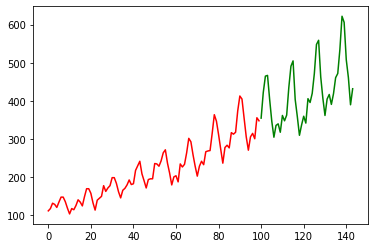

In [12]:
#所有的数据可视化显示。
print(len(df))   #打印数据长度 
#划分训练集和测试集
train = df[0:100]
test = df[100:]
#可视化数据
plt.plot(train,color = 'red')
plt.plot(test, color = 'green')
plt.show()


2、准备数据

In [15]:
#定义数据集函数，使用前look_back天预测后一天的数据
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
look_back = 3   #用前3天的预测后一天的
batch_size = 1
def create_dataset(dataset):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back -1):
        x = dataset[i: i + look_back, 0]
        dataX.append(x)
        y = dataset[i + look_back, 0]
        dataY.append(y)
        print('X:%s ,Y:%s'%(x, y))
    return np.array(dataX), np.array(dataY)

#读取数据 
df = pd.read_csv("flights.csv", header=None, usecols=[2])
passenger_data =df.values[1:].astype(float)
#最大最小归一化
scaler = MinMaxScaler(feature_range=(-1, 1))
passenger_dataset = scaler.fit_transform(passenger_data)

#划分数据集
train_data = passenger_dataset[0:100, :]
test_data = passenger_dataset[100:, :]
#创建dataset
X_train, Y_train = create_dataset(train_data)
X_test, Y_test = create_dataset(test_data)
print(X_train.shape)
print(Y_train.shape)
#转换数据类型为 [样本，时间步长，特征]
X_train = np.reshape(X_train, (X_train.shape[0] , X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_train = np.reshape(Y_train, (Y_train.shape[0], 1))
Y_test = np.reshape(Y_test, (Y_test.shape[0]))


X:[-0.96911197 -0.94594595 -0.89189189] ,Y:-0.9034749034749036
X:[-0.94594595 -0.89189189 -0.9034749 ] ,Y:-0.9343629343629345
X:[-0.89189189 -0.9034749  -0.93436293] ,Y:-0.8803088803088804
X:[-0.9034749  -0.93436293 -0.88030888] ,Y:-0.8301158301158302
X:[-0.93436293 -0.88030888 -0.83011583] ,Y:-0.8301158301158302
X:[-0.88030888 -0.83011583 -0.83011583] ,Y:-0.8764478764478765
X:[-0.83011583 -0.83011583 -0.87644788] ,Y:-0.9420849420849422
X:[-0.83011583 -0.87644788 -0.94208494] ,Y:-1.0
X:[-0.87644788 -0.94208494 -1.        ] ,Y:-0.945945945945946
X:[-0.94208494 -1.         -0.94594595] ,Y:-0.9575289575289576
X:[-1.         -0.94594595 -0.95752896] ,Y:-0.9150579150579151
X:[-0.94594595 -0.95752896 -0.91505792] ,Y:-0.8571428571428572
X:[-0.95752896 -0.91505792 -0.85714286] ,Y:-0.8803088803088804
X:[-0.91505792 -0.85714286 -0.88030888] ,Y:-0.918918918918919
X:[-0.85714286 -0.88030888 -0.91891892] ,Y:-0.8262548262548264
X:[-0.88030888 -0.91891892 -0.82625483] ,Y:-0.7451737451737452
X:[-0.918

3、模型搭建

In [16]:
from torch import nn
class gru(nn.Module):
    def __init__(self, input_size=1, hidden_size=64 , num_layers=2 , output_size=1 , dropout=0, batch_first=True):  #定义网络参数，输入维度为1，隐层为64，层数为2，输出维度为1
        super(gru, self).__init__()
        # lstm的输入 #batch,seq_len, input_size   如果batch_first为True则输入为这个参数
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.dropout = dropout
        self.batch_first = batch_first
        self.rnn = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=self.batch_first, dropout=self.dropout )
        self.linear = nn.Linear(self.hidden_size, self.output_size)
    def forward(self, x, h_state):
        r_out, h_state = self.rnn(x, h_state)  # x.shape : batch, seq_len, hidden_size , hn.shape and cn.shape : num_layes * direction_numbers, batch, hidden_size
        out = self.linear(r_out[:, -1, :])
        return out , h_state


4、训练模型与结果显示

X:[-0.96911197 -0.94594595 -0.89189189] ,Y:-0.9034749034749036
X:[-0.94594595 -0.89189189 -0.9034749 ] ,Y:-0.9343629343629345
X:[-0.89189189 -0.9034749  -0.93436293] ,Y:-0.8803088803088804
X:[-0.9034749  -0.93436293 -0.88030888] ,Y:-0.8301158301158302
X:[-0.93436293 -0.88030888 -0.83011583] ,Y:-0.8301158301158302
X:[-0.88030888 -0.83011583 -0.83011583] ,Y:-0.8764478764478765
X:[-0.83011583 -0.83011583 -0.87644788] ,Y:-0.9420849420849422
X:[-0.83011583 -0.87644788 -0.94208494] ,Y:-1.0
X:[-0.87644788 -0.94208494 -1.        ] ,Y:-0.945945945945946
X:[-0.94208494 -1.         -0.94594595] ,Y:-0.9575289575289576
X:[-1.         -0.94594595 -0.95752896] ,Y:-0.9150579150579151
X:[-0.94594595 -0.95752896 -0.91505792] ,Y:-0.8571428571428572
X:[-0.95752896 -0.91505792 -0.85714286] ,Y:-0.8803088803088804
X:[-0.91505792 -0.85714286 -0.88030888] ,Y:-0.918918918918919
X:[-0.85714286 -0.88030888 -0.91891892] ,Y:-0.8262548262548264
X:[-0.88030888 -0.91891892 -0.82625483] ,Y:-0.7451737451737452
X:[-0.918

epoch:   0 loss: 0.36847121
epoch:   1 loss: 0.32434338
epoch:   2 loss: 0.27408615
epoch:   3 loss: 0.22798026
epoch:   4 loss: 0.18633214
epoch:   5 loss: 0.14903337
epoch:   6 loss: 0.11646323
epoch:   7 loss: 0.08939596
epoch:   8 loss: 0.06894534
epoch:   9 loss: 0.05647760
epoch:  10 loss: 0.05322107
epoch:  11 loss: 0.05912345
epoch:  12 loss: 0.07089811
epoch:  13 loss: 0.08196796
epoch:  14 loss: 0.08668613
epoch:  15 loss: 0.08378711
epoch:  16 loss: 0.07564396
epoch:  17 loss: 0.06575319
epoch:  18 loss: 0.05691426
epoch:  19 loss: 0.05059817
epoch:  20 loss: 0.04709030
epoch:  21 loss: 0.04592853
epoch:  22 loss: 0.04633370
epoch:  23 loss: 0.04750687
epoch:  24 loss: 0.04878448
epoch:  25 loss: 0.04969190
epoch:  26 loss: 0.04994065
epoch:  27 loss: 0.04940221
epoch:  28 loss: 0.04807690
epoch:  29 loss: 0.04606592
epoch:  30 loss: 0.04354756
epoch:  31 loss: 0.04075608
epoch:  32 loss: 0.03795892
epoch:  33 loss: 0.03542854
epoch:  34 loss: 0.03340471
epoch:  35 loss: 0.0

epoch: 300 loss: 0.01622677
epoch: 301 loss: 0.01641099
epoch: 302 loss: 0.01587841
epoch: 303 loss: 0.01489415
epoch: 304 loss: 0.01394395
epoch: 305 loss: 0.01352066
epoch: 306 loss: 0.01387155
epoch: 307 loss: 0.01481748
epoch: 308 loss: 0.01579325
epoch: 309 loss: 0.01617196
epoch: 310 loss: 0.01569668
epoch: 311 loss: 0.01467281
epoch: 312 loss: 0.01374360
epoch: 313 loss: 0.01344442
epoch: 314 loss: 0.01389163
epoch: 315 loss: 0.01478226
epoch: 316 loss: 0.01562041
epoch: 317 loss: 0.01598553
epoch: 318 loss: 0.01571213
epoch: 319 loss: 0.01494019
epoch: 320 loss: 0.01404547
epoch: 321 loss: 0.01347600
epoch: 322 loss: 0.01353722
epoch: 323 loss: 0.01420659
epoch: 324 loss: 0.01509759
epoch: 325 loss: 0.01565771
epoch: 326 loss: 0.01552316
epoch: 327 loss: 0.01477556
epoch: 328 loss: 0.01388185
epoch: 329 loss: 0.01336713
epoch: 330 loss: 0.01348785
epoch: 331 loss: 0.01412349
epoch: 332 loss: 0.01489925
epoch: 333 loss: 0.01540958
epoch: 334 loss: 0.01540966
epoch: 335 loss: 0.0

epoch: 623 loss: 0.00704507
epoch: 624 loss: 0.00704221
epoch: 625 loss: 0.00703935
epoch: 626 loss: 0.00703644
epoch: 627 loss: 0.00703355
epoch: 628 loss: 0.00703077
epoch: 629 loss: 0.00702809
epoch: 630 loss: 0.00702541
epoch: 631 loss: 0.00702267
epoch: 632 loss: 0.00701991
epoch: 633 loss: 0.00701723
epoch: 634 loss: 0.00701468
epoch: 635 loss: 0.00701218
epoch: 636 loss: 0.00700968
epoch: 637 loss: 0.00700716
epoch: 638 loss: 0.00700470
epoch: 639 loss: 0.00700233
epoch: 640 loss: 0.00700000
epoch: 641 loss: 0.00699764
epoch: 642 loss: 0.00699524
epoch: 643 loss: 0.00699284
epoch: 644 loss: 0.00699050
epoch: 645 loss: 0.00698821
epoch: 646 loss: 0.00698594
epoch: 647 loss: 0.00698363
epoch: 648 loss: 0.00698132
epoch: 649 loss: 0.00697904
epoch: 650 loss: 0.00697681
epoch: 651 loss: 0.00697457
epoch: 652 loss: 0.00697231
epoch: 653 loss: 0.00697001
epoch: 654 loss: 0.00696773
epoch: 655 loss: 0.00696549
epoch: 656 loss: 0.00696330
epoch: 657 loss: 0.00696110
epoch: 658 loss: 0.0

epoch: 918 loss: 0.00640640
epoch: 919 loss: 0.00640443
epoch: 920 loss: 0.00640245
epoch: 921 loss: 0.00640047
epoch: 922 loss: 0.00639848
epoch: 923 loss: 0.00639649
epoch: 924 loss: 0.00639448
epoch: 925 loss: 0.00639247
epoch: 926 loss: 0.00639045
epoch: 927 loss: 0.00638842
epoch: 928 loss: 0.00638638
epoch: 929 loss: 0.00638434
epoch: 930 loss: 0.00638228
epoch: 931 loss: 0.00638021
epoch: 932 loss: 0.00637814
epoch: 933 loss: 0.00637605
epoch: 934 loss: 0.00637395
epoch: 935 loss: 0.00637185
epoch: 936 loss: 0.00636973
epoch: 937 loss: 0.00636760
epoch: 938 loss: 0.00636546
epoch: 939 loss: 0.00636331
epoch: 940 loss: 0.00636114
epoch: 941 loss: 0.00635897
epoch: 942 loss: 0.00635678
epoch: 943 loss: 0.00635457
epoch: 944 loss: 0.00635236
epoch: 945 loss: 0.00635013
epoch: 946 loss: 0.00634789
epoch: 947 loss: 0.00634563
epoch: 948 loss: 0.00634336
epoch: 949 loss: 0.00634108
epoch: 950 loss: 0.00633878
epoch: 951 loss: 0.00633647
epoch: 952 loss: 0.00633415
epoch: 953 loss: 0.0

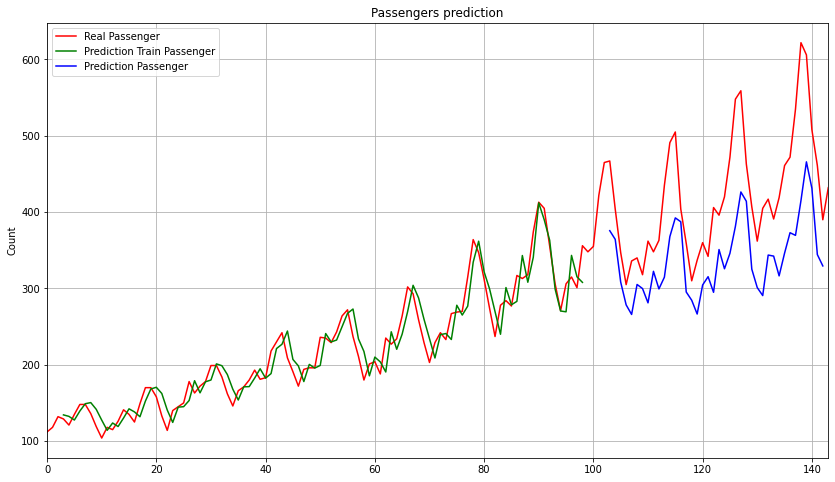

In [18]:
#导入使用到的包
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
look_back = 3   #用前3天的预测后一天的
batch_size = 1
 
#定义数据集函数，使用前look_back天预测后一天的数据
def create_dataset(dataset):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back -1):
        x = dataset[i: i + look_back, 0]
        dataX.append(x)
        y = dataset[i + look_back, 0]
        dataY.append(y)
        print('X:%s ,Y:%s'%(x, y))
    return np.array(dataX), np.array(dataY)

#对数据进行处理
df = pd.read_csv("flights.csv", header=None, usecols=[2])
Flights_data =df.values[1:].astype(float)
#最大最小归一化
scaler = MinMaxScaler(feature_range=(-1, 1))
Flights_dataset = scaler.fit_transform(Flights_data)
#划分数据集
train_data = Flights_dataset[0:100, :]
test_data = Flights_dataset[100:, :]
 
#创建dataset
X_train, Y_train = create_dataset(train_data)
X_test, Y_test = create_dataset(test_data)
print(X_train.shape)
print(Y_train.shape)

#转换数据类型为 [样本，时间步长，特征]
X_train = np.reshape(X_train, (X_train.shape[0] , X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_train = np.reshape(Y_train, (Y_train.shape[0], 1))
Y_test = np.reshape(Y_test, (Y_test.shape[0]))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.from_numpy(X_train)
y = torch.from_numpy(Y_train)
x1 = torch.from_numpy(X_test)
print(X_train.shape)
print(x.shape)

#定义模型
class gru(nn.Module): 
    def __init__(self, input_size=1, hidden_size=64 , num_layers=2 , output_size=1 , dropout=0, batch_first=True): #定义网络参数，输入维度为1，隐层为64，层数为2，输出维度为1
        super(gru, self).__init__()
        # lstm的输入 #batch,seq_len, input_size   如果batch_first为True则输入为这个参数
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.dropout = dropout
        self.batch_first = batch_first
        self.rnn = nn.GRU(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=self.batch_first, dropout=self.dropout )
        self.linear = nn.Linear(self.hidden_size, self.output_size)
    def forward(self, x, h_state):
        r_out, h_state = self.rnn(x, h_state)  # x.shape : batch, seq_len, hidden_size , hn.shape and cn.shape : num_layes * direction_numbers, batch, hidden_size
        out = self.linear(r_out[:, -1, :])
        return out , h_state
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = gru().to(device)
#model

#定义损失函数和优化器，损失函数选用MSE，优化器选用Adam，初始学习率为0.001
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)
#训练模型，训练轮数为1000
epochs = 1000
h_state = None  # 初始化 hidden state
for i in range(epochs):
    inputs = Variable(x)
    pred , h_state= model(inputs.float().to(device), h_state)
    label = Variable(y).float()
    h_state = h_state.data
    loss = loss_function(pred, label.float().to(device)) #通过损失函数计算损失
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()  #梯度清零
    print(f'epoch: {i:3} loss: {loss.item():10.8f}')   #输出损失
predict_train = pred
predict_train = predict_train.detach().cpu().numpy()
actual_train = Y_train
torch.save(model, 'passengers.pth')  #保存模型
#yuce
#model = torch.load('passengers.pth')
model = model.eval()
h_state = None
predictions, h_state = model(x1.float().to(device), h_state)
print(predictions.shape)
pre = predictions.detach().cpu().numpy()
print(pre.shape)
#将预测数据和真实数据反归一化显示真实结果
predict_train = scaler.inverse_transform(np.array(predict_train).reshape(-1, 1))
#actual_train = scaler.inverse_transform(np.array(actual_train).reshape(-1, 1))
actual_predictions = scaler.inverse_transform(np.array(pre).reshape(-1, 1))
#actual_test = scaler.inverse_transform(np.array(Y_test).reshape(-1, 1))
Flights_dataset = scaler.inverse_transform(np.array(Flights_dataset).reshape(-1, 1))
#print(actual_test)
print(actual_predictions)
predict_train_plot = np.empty_like(Flights_dataset)
predict_train_plot[:, :] = np.nan
predict_train_plot[look_back: len(predict_train) + look_back , :] = predict_train
predict_test_plot = np.empty_like(Flights_dataset)
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_train) +look_back*2 +1: len(Flights_dataset) -1, :] = actual_predictions
#可视化显示结果
plt.figure(figsize=(14,8))
plt.title('Passengers prediction')
plt.ylabel('Count')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(Flights_dataset,color = 'red', label='Real Passenger')
plt.plot(predict_train_plot,color = 'green', label = 'Prediction Train Passenger')
plt.plot(predict_test_plot, color = 'blue', label = 'Prediction Passenger')
plt.legend()
plt.savefig('passengers-GRU.png')  #保存结果
plt.show()


# LSTM预测温度

1、数据描述

In [20]:
#导入相关的包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
#读取数据
df = pd.read_csv('jena_climate_2009_2016.csv')
print('前五行数据为：\n',df[:5])


前五行数据为：
              Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.0

In [21]:
#显示后5行数据。
print('后五行数据为：\n',df[-5:])


后五行数据为：
                   Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  \
420446  31.12.2016 23:20:00   1000.07     -4.05    269.10        -8.13   
420447  31.12.2016 23:30:00    999.93     -3.35    269.81        -8.06   
420448  31.12.2016 23:40:00    999.82     -3.16    270.01        -8.21   
420449  31.12.2016 23:50:00    999.81     -4.23    268.94        -8.53   
420450  01.01.2017 00:00:00    999.82     -4.82    268.36        -8.42   

        rh (%)  VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
420446   73.10          4.52          3.30          1.22       2.06   
420447   69.71          4.77          3.32          1.44       2.07   
420448   67.91          4.84          3.28          1.55       2.05   
420449   71.80          4.46          3.20          1.26       1.99   
420450   75.70          4.27          3.23          1.04       2.01   

        H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
420446             3.30       1292.98      0

In [23]:
#所有数据可视化显示。
path = 'jena_climate_2009_2016.csv'
f = open(path)
df = f.read()
f.close()
lines = df.split('\n')
header = lines[0].split(',')
lines = lines[1:]
float_data = np.zeros((len(lines),len(header) - 1))
#读取温度的列数据
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp) #显示温度数据
plt.show()


2、数据处理

In [28]:
class Data:
    def __init__(self, config):
        self.config = config
        self.data, self.data_column_name = self.read_data()

        self.data_num = self.data.shape[0]
        self.train_num = int(self.data_num * self.config.train_data_rate)

        self.mean = np.mean(self.data, axis=0)              # 数据的均值和方差
        self.std = np.std(self.data, axis=0)
        self.norm_data = (self.data - self.mean)/self.std   # 归一化，去量纲

        self.start_num_in_test = 0      # 测试集中前几天的数据会被删掉，因为它不够一个time_step

    def read_data(self):                # 读取初始数据
        if self.config.debug_mode:
            init_data = pd.read_csv(self.config.train_data_path, nrows=self.config.debug_num,
                                    usecols=self.config.feature_columns)
        else:
            init_data = pd.read_csv(self.config.train_data_path, usecols=self.config.feature_columns)
        return init_data.values, init_data.columns.tolist()     # .columns.tolist() 是获取列名

    def get_train_and_valid_data(self):
        feature_data = self.norm_data[:self.train_num]
        label_data = self.norm_data[self.config.predict_day : self.config.predict_day + self.train_num,
                                    self.config.label_in_feature_index]    # 将延后几天的数据作为label

        if not self.config.do_continue_train:
            train_x = [feature_data[i:i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
            train_y = [label_data[i:i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
        else:
            train_x = [feature_data[start_index + i*self.config.time_step : start_index + (i+1)*self.config.time_step]
                       for start_index in range(self.config.time_step)
                       for i in range((self.train_num - start_index) // self.config.time_step)]
            train_y = [label_data[start_index + i*self.config.time_step : start_index + (i+1)*self.config.time_step]
                       for start_index in range(self.config.time_step)
                       for i in range((self.train_num - start_index) // self.config.time_step)]

        train_x, train_y = np.array(train_x), np.array(train_y)

        train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=self.config.valid_data_rate,
                                                              random_state=self.config.random_seed,
                                                              shuffle=self.config.shuffle_train_data)   # 划分训练和验证集，并打乱
        return train_x, valid_x, train_y, valid_y

    def get_test_data(self, return_label_data=False):
        feature_data = self.norm_data[self.train_num:]
        sample_interval = min(feature_data.shape[0], self.config.time_step)     # 防止time_step大于测试集数量
        self.start_num_in_test = feature_data.shape[0] % sample_interval  # 这些天的数据不够一个sample_interval
        time_step_size = feature_data.shape[0] // sample_interval
        test_x = [feature_data[self.start_num_in_test+i*sample_interval : self.start_num_in_test+(i+1)*sample_interval]
                   for i in range(time_step_size)]
        if return_label_data:       # 实际应用中的测试集是没有label数据的
            label_data = self.norm_data[self.train_num + self.start_num_in_test:, self.config.label_in_feature_index]
            return np.array(test_x), label_data
        return np.array(test_x)

3、模型搭建

In [2]:
from torch.nn import Module, LSTM, Linear
class Net(Module):
    def __init__(self, config):
        super(Net, self).__init__()
        self.lstm = LSTM(input_size=config.input_size, hidden_size=config.hidden_size,
                         num_layers=config.lstm_layers, batch_first=True, dropout=config.dropout_rate)
        self.linear = Linear(in_features=config.hidden_size, out_features=config.output_size)

    def forward(self, x, hidden=None):
        lstm_out, hidden = self.lstm(x, hidden)
        linear_out = self.linear(lstm_out)
        return linear_out, hidden


4、训练模型和预测结果

In [11]:
import torch
from torch.nn import Module, LSTM, Linear
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
def train(config, logger, train_and_valid_data):

    train_X, train_Y, valid_X, valid_Y = train_and_valid_data
    train_X, train_Y = torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).float()     # 先转为Tensor
    train_loader = DataLoader(TensorDataset(train_X, train_Y), batch_size=config.batch_size)    # DataLoader可自动生成可训练的batch数据

    valid_X, valid_Y = torch.from_numpy(valid_X).float(), torch.from_numpy(valid_Y).float()
    valid_loader = DataLoader(TensorDataset(valid_X, valid_Y), batch_size=config.batch_size)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # CPU训练还是GPU
    print(device)
    model = Net(config).to(device)      # 如果是GPU训练， .to(device) 会把模型/数据复制到GPU显存中
    if config.add_train:                # 如果是增量训练，会先加载原模型参数
        model.load_state_dict(torch.load(config.model_save_path + config.model_name))
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = torch.nn.MSELoss()      # 这两句是定义优化器和loss

    valid_loss_min = float("inf")
    bad_epoch = 0
    global_step = 0
    for epoch in range(config.epoch):
        logger.info("Epoch {}/{}".format(epoch, config.epoch))
        model.train()                   # pytorch中，训练时要转换成训练模式
        train_loss_array = []
        hidden_train = None
        for i, _data in enumerate(train_loader):
            _train_X, _train_Y = _data[0].to(device),_data[1].to(device)
            optimizer.zero_grad()               # 训练前要将梯度信息置 0
            pred_Y, hidden_train = model(_train_X, hidden_train)    # 这里走的就是前向计算forward函数

            if not config.do_continue_train:
                hidden_train = None             # 如果非连续训练，把hidden重置即可
            else:
                h_0, c_0 = hidden_train
                h_0.detach_(), c_0.detach_()    # 去掉梯度信息
                hidden_train = (h_0, c_0)
            loss = criterion(pred_Y, _train_Y)  # 计算loss
            loss.backward()                     # 将loss反向传播
            optimizer.step()                    # 用优化器更新参数
            train_loss_array.append(loss.item())
            global_step += 1

        # 以下为早停机制，当模型训练连续config.patience个epoch都没有使验证集预测效果提升时，就停止，防止过拟合
        model.eval()                    # pytorch中，预测时要转换成预测模式
        valid_loss_array = []
        hidden_valid = None
        for _valid_X, _valid_Y in valid_loader:
            _valid_X, _valid_Y = _valid_X.to(device), _valid_Y.to(device)
            pred_Y, hidden_valid = model(_valid_X, hidden_valid)
            if not config.do_continue_train: hidden_valid = None
            loss = criterion(pred_Y, _valid_Y)  # 验证过程只有前向计算，无反向传播过程
            valid_loss_array.append(loss.item())

        train_loss_cur = np.mean(train_loss_array)
        valid_loss_cur = np.mean(valid_loss_array)
        logger.info("The train loss is {:.6f}. ".format(train_loss_cur) +
              "The valid loss is {:.6f}.".format(valid_loss_cur))
        
        if valid_loss_cur < valid_loss_min:
            valid_loss_min = valid_loss_cur
            bad_epoch = 0
            torch.save(model.state_dict(), config.model_save_path + config.model_name)  # 模型保存
        else:
            bad_epoch += 1
            if bad_epoch >= config.patience:    # 如果验证集指标连续patience个epoch没有提升，就停掉训练
                logger.info(" The training stops early in epoch {}".format(epoch))
                break


def predict(config, test_X):
    # 获取测试数据
    test_X = torch.from_numpy(test_X).float()
    test_set = TensorDataset(test_X)
    test_loader = DataLoader(test_set, batch_size=1)

    # 加载模型
    device = torch.device("cuda:0" if config.use_cuda and torch.cuda.is_available() else "cpu")
    model = Net(config).to(device)
    model.load_state_dict(torch.load(config.model_save_path + config.model_name))   # 加载模型参数

    # 先定义一个tensor保存预测结果
    result = torch.Tensor().to(device)

    # 预测过程
    model.eval()
    hidden_predict = None
    for _data in test_loader:
        data_X = _data[0].to(device)
        pred_X, hidden_predict = model(data_X, hidden_predict)
        # if not config.do_continue_train: hidden_predict = None    # 实验发现无论是否是连续训练模式，把上一个time_step的hidden传入下一个效果都更好
        cur_pred = torch.squeeze(pred_X, dim=0)
        result = torch.cat((result, cur_pred), dim=0)

    return result.detach().cpu().numpy()    # 先去梯度信息，如果在gpu要转到cpu，最后要返回numpy数据
import pandas as pd
import numpy as np
import os
import sys
import time
import logging
from logging.handlers import RotatingFileHandler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class Config:
    # 数据参数
    feature_columns = list(range(1, 15))     # 要作为feature的列，按原数据从0开始计算，也可以用list 如 [2,4,6,8] 设置
    label_columns = [2]                  # 要预测的列，按原数据从0开始计算, 如同时预测第四，五列 最低价和最高价
    # label_in_feature_index = [feature_columns.index(i) for i in label_columns]  # 这样写不行
    label_in_feature_index = (lambda x,y: [x.index(i) for i in y])(feature_columns, label_columns)  # 因为feature不一定从0开始

    predict_day = 1             # 预测未来几天

    # 网络参数
    input_size = len(feature_columns)
    output_size = len(label_columns)

    hidden_size = 128           # LSTM的隐藏层大小，也是输出大小
    lstm_layers = 2             # LSTM的堆叠层数
    dropout_rate = 0.2          # dropout概率
    time_step = 20              # 这个参数很重要，是设置用前多少天的数据来预测，也是LSTM的time step数，请保证训练数据量大于它

    # 训练参数
    do_train = True
    do_predict = True
    add_train = False           # 是否载入已有模型参数进行增量训练
    shuffle_train_data = True   # 是否对训练数据做shuffle
    use_cuda = False            # 是否使用GPU训练

    train_data_rate = 0.95      # 训练数据占总体数据比例，测试数据就是 1-train_data_rate
    valid_data_rate = 0.15      # 验证数据占训练数据比例，验证集在训练过程使用，为了做模型和参数选择

    batch_size = 64
    learning_rate = 0.001
    epoch = 20                  # 整个训练集被训练多少遍，不考虑早停的前提下
    patience = 5                # 训练多少epoch，验证集没提升就停掉
    random_seed = 42            # 随机种子，保证可复现

    do_continue_train = False    # 每次训练把上一次的final_state作为下一次的init_state，仅用于RNN类型模型，目前仅支持pytorch
    continue_flag = ""           # 但实际效果不佳，可能原因：仅能以 batch_size = 1 训练
    if do_continue_train:
        shuffle_train_data = False
        batch_size = 1
        continue_flag = "continue_"

    # 训练模式
    debug_mode = False  # 调试模式下，是为了跑通代码，追求快
    debug_num = 500  # 仅用debug_num条数据来调试

    # 框架参数
    used_frame = "pytorch"  # 选择的深度学习框架，不同的框架模型保存后缀不一样
    model_postfix = {"pytorch": ".pth", "keras": ".h5", "tensorflow": ".ckpt"}
    model_name = "model_" + continue_flag + used_frame + model_postfix[used_frame]

    # 路径参数
    train_data_path = "jena_climate_2009_2016.csv"
    model_save_path = "./" + used_frame + "/"
    figure_save_path = "./figure/"

    do_log_print_to_screen = True
    do_log_save_to_file = False                  # 是否将config和训练过程记录到log
    do_figure_save = True
    if not os.path.exists(figure_save_path):
        os.mkdir(figure_save_path)



class Data:
    def __init__(self, config):
        self.config = config
        self.data, self.data_column_name = self.read_data()

        self.data_num = self.data.shape[0]
        self.train_num = int(self.data_num * self.config.train_data_rate)

        self.mean = np.mean(self.data, axis=0)              # 数据的均值和方差
        self.std = np.std(self.data, axis=0)
        self.norm_data = (self.data - self.mean)/self.std   # 归一化，去量纲

        self.start_num_in_test = 0      # 测试集中前几天的数据会被删掉，因为它不够一个time_step

    def read_data(self):                # 读取初始数据
        if self.config.debug_mode:
            init_data = pd.read_csv(self.config.train_data_path, nrows=self.config.debug_num,
                                    usecols=self.config.feature_columns)
        else:
            init_data = pd.read_csv(self.config.train_data_path, usecols=self.config.feature_columns)
        return init_data.values, init_data.columns.tolist()     # .columns.tolist() 是获取列名

    def get_train_and_valid_data(self):
        feature_data = self.norm_data[:self.train_num]
        label_data = self.norm_data[self.config.predict_day : self.config.predict_day + self.train_num,
                                    self.config.label_in_feature_index]    # 将延后几天的数据作为label

        if not self.config.do_continue_train:
            train_x = [feature_data[i:i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
            train_y = [label_data[i:i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
        else:
            train_x = [feature_data[start_index + i*self.config.time_step : start_index + (i+1)*self.config.time_step]
                       for start_index in range(self.config.time_step)
                       for i in range((self.train_num - start_index) // self.config.time_step)]
            train_y = [label_data[start_index + i*self.config.time_step : start_index + (i+1)*self.config.time_step]
                       for start_index in range(self.config.time_step)
                       for i in range((self.train_num - start_index) // self.config.time_step)]

        train_x, train_y = np.array(train_x), np.array(train_y)

        train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=self.config.valid_data_rate,
                                                              random_state=self.config.random_seed,
                                                              shuffle=self.config.shuffle_train_data)   # 划分训练和验证集，并打乱
        return train_x, valid_x, train_y, valid_y

    def get_test_data(self, return_label_data=False):
        feature_data = self.norm_data[self.train_num:]
        sample_interval = min(feature_data.shape[0], self.config.time_step)     # 防止time_step大于测试集数量
        self.start_num_in_test = feature_data.shape[0] % sample_interval  # 这些天的数据不够一个sample_interval
        time_step_size = feature_data.shape[0] // sample_interval
        test_x = [feature_data[self.start_num_in_test+i*sample_interval : self.start_num_in_test+(i+1)*sample_interval]
                   for i in range(time_step_size)]
        if return_label_data:       # 实际应用中的测试集是没有label数据的
            label_data = self.norm_data[self.train_num + self.start_num_in_test:, self.config.label_in_feature_index]
            return np.array(test_x), label_data
        return np.array(test_x)

def load_logger(config):
    logger = logging.getLogger()
    logger.setLevel(level=logging.DEBUG)

    # StreamHandler
    if config.do_log_print_to_screen:
        stream_handler = logging.StreamHandler(sys.stdout)
        stream_handler.setLevel(level=logging.INFO)
        formatter = logging.Formatter(datefmt='%Y/%m/%d %H:%M:%S',
                                      fmt='[ %(asctime)s ] %(message)s')
        stream_handler.setFormatter(formatter)
        logger.addHandler(stream_handler)

    # FileHandler
    if config.do_log_save_to_file:
        file_handler = RotatingFileHandler(config.log_save_path + "out.log", maxBytes=1024000, backupCount=5)
        file_handler.setLevel(level=logging.INFO)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

        # 把config信息也记录到log 文件中
        config_dict = {}
        for key in dir(config):
            if not key.startswith("_"):
                config_dict[key] = getattr(config, key)
        config_str = str(config_dict)
        config_list = config_str[1:-1].split(", '")
        config_save_str = "\nConfig:\n" + "\n'".join(config_list)
        logger.info(config_save_str)

    return logger

def draw(config: Config, origin_data: Data, logger, predict_norm_data: np.ndarray):
    label_data = origin_data.data[origin_data.train_num + origin_data.start_num_in_test : ,
                                            config.label_in_feature_index]
    predict_data = predict_norm_data * origin_data.std[config.label_in_feature_index] + \
                   origin_data.mean[config.label_in_feature_index]   # 通过保存的均值和方差还原数据
    assert label_data.shape[0]==predict_data.shape[0], "The element number in origin and predicted data is different"

    label_name = [origin_data.data_column_name[i] for i in config.label_in_feature_index]
    label_column_num = len(config.label_columns)


    loss = np.mean((label_data[config.predict_day:] - predict_data[:-config.predict_day] ) ** 2, axis=0)
    loss_norm = loss/(origin_data.std[config.label_in_feature_index] ** 2)
    logger.info("The mean squared error of stock {} is ".format(label_name) + str(loss_norm))

    label_X = range(origin_data.data_num - origin_data.train_num - origin_data.start_num_in_test)
    predict_X = [ x + config.predict_day for x in label_X]

    if not sys.platform.startswith('linux'):    # 无桌面的Linux下无法输出，如果是有桌面的Linux，如Ubuntu，可去掉这一行
        for i in range(label_column_num):
            plt.figure(i+1)                     # 预测数据绘制
            plt.plot(label_X, label_data[:, i], label='label')
            plt.plot(predict_X, predict_data[:, i], label='predict')
            plt.legend()
            plt.title("Predict temp {}  with {}".format(label_name[i], config.used_frame))
            logger.info("The predicted temp {} for the next {} day(s) is: ".format(label_name[i], config.predict_day) +
                  str(np.squeeze(predict_data[-config.predict_day:, i])))
            if config.do_figure_save:
                plt.savefig(config.figure_save_path+"{}predict_{}_with_{}.png".format(config.continue_flag, label_name[i], config.used_frame))

        plt.show()


def main(config):
    logger = load_logger(config)
    try:
        np.random.seed(config.random_seed)  # 设置随机种子，保证可复现
        data_gainer = Data(config)

        if config.do_train:
            train_X, valid_X, train_Y, valid_Y = data_gainer.get_train_and_valid_data()
            train(config, logger, [train_X, train_Y, valid_X, valid_Y])

        if config.do_predict:
            test_X, test_Y = data_gainer.get_test_data(return_label_data=True)
            pred_result = predict(config, test_X)       # 这里输出的是未还原的归一化预测数据
            draw(config, data_gainer, logger, pred_result)
    except Exception:
        logger.error("Run Error", exc_info=True)



import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])

con = Config()
for key in dir(args):               # dir(args) 函数获得args所有的属性
    if not key.startswith("_"):     # 去掉 args 自带属性，比如__name__等
        setattr(con, key, getattr(args, key))   # 将属性值赋给Config

main(con)


cuda:0
[ 2022/04/03 20:02:04 ] Epoch 0/20
[ 2022/04/03 20:02:04 ] Epoch 0/20
[ 2022/04/03 20:02:04 ] Epoch 0/20
[ 2022/04/03 20:02:04 ] Epoch 0/20
[ 2022/04/03 20:02:45 ] The train loss is 0.003966. The valid loss is 0.001091.
[ 2022/04/03 20:02:45 ] The train loss is 0.003966. The valid loss is 0.001091.
[ 2022/04/03 20:02:45 ] The train loss is 0.003966. The valid loss is 0.001091.
[ 2022/04/03 20:02:45 ] The train loss is 0.003966. The valid loss is 0.001091.
[ 2022/04/03 20:02:45 ] Epoch 1/20
[ 2022/04/03 20:02:45 ] Epoch 1/20
[ 2022/04/03 20:02:45 ] Epoch 1/20
[ 2022/04/03 20:02:45 ] Epoch 1/20
[ 2022/04/03 20:03:33 ] The train loss is 0.001013. The valid loss is 0.000716.
[ 2022/04/03 20:03:33 ] The train loss is 0.001013. The valid loss is 0.000716.
[ 2022/04/03 20:03:33 ] The train loss is 0.001013. The valid loss is 0.000716.
[ 2022/04/03 20:03:33 ] The train loss is 0.001013. The valid loss is 0.000716.
[ 2022/04/03 20:03:33 ] Epoch 2/20
[ 2022/04/03 20:03:33 ] Epoch 2/20
[ 2